In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#1.Preprocess Data

## 1.1 Build the dataset  (No need to run for train and evaluate)
with sentences that has a length < 10. The dataset is saved for reloading.

In [ ]:
# method to process each sentence
# convert french accent characters to latin characters, lowercase characters, remove punctuations and non-printable characters and words with numbers inside
def normalize_sentence(sen):
  import string
  from string import punctuation
  import re
  from unicodedata import normalize

  sen = normalize('NFD', sen).encode('ascii', 'ignore')   # convert the french accent characters into latin characters
  sen = sen.decode('UTF-8')
  dicts={i:'' for i in punctuation}           # for removing punctuations
  punc_table=str.maketrans(dicts)
  sen = sen.translate(punc_table)             # remove punctuations
  sen = sen.lower().split()                   # split the word in each line by space, lowercase all 
  re_print = re.compile('[^%s]' % re.escape(string.printable))
  sen = [re_print.sub('', w) for w in sen]    # remove non-printable chars in each word
  sen = [w for w in sen if w.isalpha()]       # remove words with numbers
  return sen

print(normalize_sentence("'Je déclare reprise la session *du Parlement? européen q*ui ava98it été interrompue le vendredi 17 décembre dernier"))

['je', 'declare', 'reprise', 'la', 'session', 'du', 'parlement', 'europeen', 'qui', 'ete', 'interrompue', 'le', 'vendredi', 'decembre', 'dernier']


In [ ]:
# method to prepare language pairs
def prepare_language_pair(input_lang_path, target_lang_path, switch_in_out=False, filter_sentence_length=10):
  print("Processing input language file: {}".format(input_lang_path))
  with open(input_lang_path,"r") as f:
    lines = f.readlines()
  print("There are {} sentences.".format(len(lines)))
  input_sen = [normalize_sentence(line) for line in lines]

  print("Processing target language file: {}".format(target_lang_path))
  with open(target_lang_path,"r") as f:
    lines = f.readlines()
  print("There are {} sentences.".format(len(lines)))
  target_sen = [normalize_sentence(line) for line in lines]

  pair_sen = [[], []]   # to store the sentence pairs with length less than 'filter_sentence_length' for both input and target
  for idx in range(len(input_sen)):
    if len(input_sen[idx]) < filter_sentence_length and len(target_sen[idx]) < filter_sentence_length:
      pair_sen[0].append(input_sen[idx])
      pair_sen[1].append(target_sen[idx])
  print("\n{} sentences kept.\n".format(len(pair_sen[0]))) 

  for idx in range(5):
    print("{} sentence {}".format(input_lang_path[-2:].upper(),idx+1), pair_sen[0][idx])
    print("{} sentence {}".format(target_lang_path[-2:].upper(),idx+1), pair_sen[1][idx])
  
  if switch_in_out==False:
    return pair_sen[0], pair_sen[1]  
  else: 
    return pair_sen[1], pair_sen[0]

max_sentence_length = 10
input_sen, target_sen = prepare_language_pair("/content/drive/MyDrive/NLP_Project/data/europarl-v7.fr-en.fr", \
                                              "/content/drive/MyDrive/NLP_Project/data/europarl-v7.fr-en.en", \
                                              switch_in_out=False, filter_sentence_length=max_sentence_length)

# save the input and target list to a pickle file
import pickle
with open('/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/input_sen.pkl', 'wb') as f:
  pickle.dump(input_sen, f)
  print("\n/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/input_sen.pkl saved")
with open('/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/target_sen.pkl', 'wb') as f:
  pickle.dump(target_sen, f)
  print("/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/target_sen.pkl saved\n")

# for sanity check
print(input_sen[102])
print(target_sen[102])
print(input_sen[12103])
print(target_sen[12103])

Processing input language file: /content/drive/MyDrive/NLP_Project/data/europarl-v7.fr-en.fr
There are 2007723 sentences.
Processing target language file: /content/drive/MyDrive/NLP_Project/data/europarl-v7.fr-en.en
There are 2007723 sentences.

191346 sentences kept.

FR sentence 1 ['reprise', 'de', 'la', 'session']
EN sentence 1 ['resumption', 'of', 'the', 'session']
FR sentence 2 ['le', 'parlement', 'debout', 'observe', 'une', 'minute', 'de', 'silence']
EN sentence 2 ['the', 'house', 'rose', 'and', 'observed', 'a', 'minute', 's', 'silence']
FR sentence 3 ['madame', 'la', 'presidente', 'cest', 'une', 'motion', 'de', 'procedure']
EN sentence 3 ['madam', 'president', 'on', 'a', 'point', 'of', 'order']
FR sentence 4 ['madame', 'la', 'presidente', 'cest', 'une', 'motion', 'de', 'procedure']
EN sentence 4 ['madam', 'president', 'on', 'a', 'point', 'of', 'order']
FR sentence 5 ['merci', 'monsieur', 'segni', 'je', 'le', 'ferai', 'bien', 'volontiers']
EN sentence 5 ['thank', 'you', 'mr', 'se

## 1.2 Reload datasets of input and target sentences (Run for train and evaluate)

In [3]:
# reload the saved list
def load_sentence():
  import pickle
  with open('/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/input_sen.pkl', 'rb') as f:
    input_sen = pickle.load(f)
    print("/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/input_sen.pkl loaded")
  with open('/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/target_sen.pkl', 'rb') as f:
    target_sen = pickle.load(f)
    print("/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/target_sen.pkl loaded")
  
  return input_sen, target_sen

input_sen, target_sen = load_sentence()
print()

# sanity check
print(input_sen[102])
print(target_sen[102])
print(input_sen[12103])
print(target_sen[12103])
print()

# build dictionaries for each language
def build_dictionary(sentences):
  word2index = {"SOS":0,"EOS":1}
  index2word = {0:"SOS",1:"EOS"}

  for sen in sentences:
    for w in sen:
      if w not in word2index:
        word2index[w] = len(word2index)
        index2word[len(index2word)] = w
  return word2index, index2word

sent = [['reprise', 'de', 'la', 'session'],
        ['je', 'declare', 'reprise', 'la', 'session', 'du', 'parlement', 'europeen', 'qui'],
        ['comme', 'vous', 'avez', 'pu', 'le', 'constater', 'le', 'grand', 'bogue', 'de', 'lan', 'ne'],
        ['vous', 'avez', 'souhaite', 'un', 'debat', 'a', 'ce', 'sujet', 'dans', 'les'],
        ['en', 'attendant', 'je', 'souhaiterais', 'comme', 'un', 'certain', 'nombre', 'de']]
        
w2i, i2w = build_dictionary(sent)
print("w2i has {} words.".format(len(w2i)))
print(w2i)
print("i2w has {} words.".format(len(i2w)))
print(i2w)
print()
# build dictionaries
input_w2i, input_i2w = build_dictionary(input_sen)
print("The input vocabulary has {} words:".format(len(input_w2i)))
print("The 10 items in front:", dict(list(input_w2i.items())[0:10]))
print("The 10 items in front:", dict(list(input_i2w.items())[0:10]))
target_w2i, target_i2w = build_dictionary(target_sen)
print("The target vocabulary has {} words:".format(len(target_w2i)))
print("The 10 items in front:", dict(list(target_w2i.items())[0:10]))
print("The 10 items in front:", dict(list(target_i2w.items())[0:10]))

/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/input_sen.pkl loaded
/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/target_sen.pkl loaded

['je', 'trouve', 'que', 'ce', 'nest', 'pas', 'acceptable']
['i', 'consider', 'this', 'to', 'be', 'unacceptable']
['ces', 'idees', 'ne', 'sont', 'certes', 'pas', 'neuves', 'en', 'ellesmemes']
['the', 'ideas', 'themselves', 'in', 'fact', 'are', 'not', 'new']

w2i has 35 words.
{'SOS': 0, 'EOS': 1, 'reprise': 2, 'de': 3, 'la': 4, 'session': 5, 'je': 6, 'declare': 7, 'du': 8, 'parlement': 9, 'europeen': 10, 'qui': 11, 'comme': 12, 'vous': 13, 'avez': 14, 'pu': 15, 'le': 16, 'constater': 17, 'grand': 18, 'bogue': 19, 'lan': 20, 'ne': 21, 'souhaite': 22, 'un': 23, 'debat': 24, 'a': 25, 'ce': 26, 'sujet': 27, 'dans': 28, 'les': 29, 'en': 30, 'attendant': 31, 'souhaiterais': 32, 'certain': 33, 'nombre': 34}
i2w has 35 words.
{0: 'SOS', 1: 'EOS', 2: 'reprise', 3: 'de', 4: 'la', 5: 'session', 6: 'je', 7: 'declare', 8: 'du', 9: 'parlemen

#2.Models with pretrained embedding weights - Seq2Seq LSTM/GRU Encoder/Decoder/Attention-Decoder (Run for train and evaluate)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# prepare glove weights
class PreparePretrainedWeight():
  def __init__(self,input_w2i,input_i2w,embedding_size,fasttext_directory_path="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/",lang_type=None,rebuild_wordvector=False):
    self.input_w2i = input_w2i
    self.input_i2w = input_i2w
    self.embedding_size = embedding_size
    self.fasttext_directory_path = fasttext_directory_path
    self.fasttext_txt_path = fasttext_directory_path + "cc."+lang_type+".300.vec.txt"
    self.fasttext_zip_path = fasttext_directory_path + "cc."+lang_type+".300.vec.gz"
    self.fasttext_pkl_path = fasttext_directory_path + "cc."+lang_type+".300.vec.pkl"
    self.lang_type = lang_type
    self.rebuild_wordvector = rebuild_wordvector 

  # load the pretrained weights for the embedding layer
  def generate_emb_weights(self):
    if self.lang_type is not None:
      import os
      if self.rebuild_wordvector==False and os.path.exists(self.fasttext_pkl_path):
        import pickle
        with open(self.fasttext_pkl_path, 'rb') as f:
          emb_weights = pickle.load(f)
          print("Pretrained weights at " + self.fasttext_pkl_path + " loaded")
        return emb_weights
      else:
        self.check_fasttext_file(self)
        emb_weights = self.get_fasttext_weights(self)
        return emb_weights 

  @staticmethod
  # method to process each sentence
  # convert french accent characters to latin characters, lowercase characters, remove punctuations and non-printable characters and words with numbers inside
  def normalize_sentence(sen):
    import string
    from string import punctuation
    import re
    from unicodedata import normalize

    sen = normalize('NFD', sen).encode('ascii', 'ignore')   # convert the french accent characters into latin characters
    sen = sen.decode('UTF-8')
    dicts={i:'' for i in punctuation}           # for removing punctuations
    punc_table=str.maketrans(dicts)
    sen = sen.translate(punc_table)             # remove punctuations
    sen = sen.lower().split()                   # split the word in each line by space, lowercase all 
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    sen = [re_print.sub('', w) for w in sen]    # remove non-printable chars in each word
    sen = [w for w in sen if w.isalpha()]       # remove words with numbers
    return sen

  @staticmethod
  # check whether glove file is ready, if not, download the file "cc."+lang_type+".300.vec.gz"
  def check_fasttext_file(self):
    import os
    import urllib
    import gzip
    import shutil
    while True:
        if not os.path.exists(self.fasttext_txt_path):    # if "cc."+lang_type+".300.vec.txt" does not exist
            print(self.fasttext_txt_path +" is not ready.")
            if not os.path.exists(self.fasttext_zip_path):    # if "cc."+lang_type+".300.vec.gz" does not exist
                # download the dataset
                print("Downloading {} ...".format(self.fasttext_zip_path))
                url = "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc." + self.lang_type + ".300.vec.gz"
                local_path = self.fasttext_zip_path
                urllib.request.urlretrieve(url, local_path)
                print("{} downloaded!".format(self.fasttext_zip_path))
            else:
                print(self.fasttext_zip_path +" exists.")
                print("Unzipping {} ...".format(self.fasttext_zip_path))
                with gzip.open(self.fasttext_zip_path, 'rb') as f_in:
                    with open(self.fasttext_txt_path, 'wb') as f_out:
                        shutil.copyfileobj(f_in, f_out)
                        print(self.fasttext_txt_path + " extracted.")   
        else:
            print(self.fasttext_txt_path + " is ready.")
            break

  @staticmethod
  # method to get the glove weights to initialize the embedding layer
  def get_fasttext_weights(self):
    from string import punctuation
    words_emb = {}  # save the word to embedding dictionary, the format is 'word':[value1,value2,...,value300]
    with open(self.fasttext_txt_path, "r") as f:
      print("Reading lines ...")
      lines = f.readlines()
      print("Lines read!")
      for ln in lines:
        ln_ = ln.split()
        word = None if len(normalize_sentence(ln_[0])) == 0 or any(p in ln_[0] for p in punctuation) else normalize_sentence(ln_[0])
        word = word[0] if word is not None else ""  # get the normalized french word
        if word is not "" and word in self.input_w2i:      # it's a word with characters
          emb = ln_[1:]
          emb = [float(num) for num in emb]
          words_emb[word] = emb
  
    idx2emb = {}    # save the index to embedding dictionary, the format is idx:[value1,value2,...,value300]
    for idx in range(len(self.input_i2w)):
        if self.input_i2w[idx] in words_emb:
            idx2emb[idx] = words_emb[self.input_i2w[idx]]
        else:
            idx2emb[idx] = [0.0] * 300
    word_emb_data = [idx2emb[idx] for idx in range(len(self.input_i2w))]

    # save the weights for reloading later
    import pickle
    with open(self.fasttext_pkl_path, 'wb') as f:
      pickle.dump(word_emb_data, f)
      print("Weights saved at {}.".format(self.fasttext_pkl_path))
    
    return word_emb_data

# 4.1, 4.2
class RNNEncoder(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, emb_weights=None, freeze_emb=False):
    super(RNNEncoder, self).__init__()

    self.input_size = input_size
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size
    self.emb_weights = emb_weights              # the pretrained embedding weights

    self.embedding = nn.Embedding(input_size, embedding_size)
    self.rnn = nn.RNN(embedding_size, hidden_size, bidirectional = False, batch_first = True)

    # initialize embeddings
    self.initEmbedding(self)

    # freeze embedding layer
    if freeze_emb==True:
      self.embedding.weight.requires_grad = False
      print("RNN Encoder embedding layer is freezed.")

  def forward(self, input, hidden):
    embedded = self.embedding(input).view(1, 1, -1)
    output = embedded
    output, hidden = self.rnn(output, hidden)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, 1, self.hidden_size)

  #  method to initialize the embedding layer weights
  def initEmbedding(self, initrange=1):
    if self.emb_weights is None:
        self.embedding.weight.data.uniform_(0, 1)
        print("RNN Encoder embedding layer randomly initialized.")
    else:
        # if the pretrained weights is not None, initialize the embedding layer with the weights
        self.emb_weights = torch.FloatTensor(self.emb_weights)                        
        self.embedding.from_pretrained(self.emb_weights)
        print("RNN Encoder embedding layer initialized with the FastText weights:\n", self.emb_weights)


# for 4.1, 4.2
class RNNDecoder(nn.Module):
  def __init__(self, output_size, embedding_size, hidden_size, emb_weights=None, freeze_emb=False):
    super(RNNDecoder, self).__init__()

    self.output_size = output_size
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size
    self.emb_weights = emb_weights              # the pretrained embedding weights

    self.embedding = nn.Embedding(output_size, embedding_size)
    self.rnn = nn.RNN(embedding_size, hidden_size, bidirectional = False, batch_first = True)

    self.out = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim = 1)

    # initialize embeddings
    self.initEmbedding(self)

    # freeze embedding layer
    if freeze_emb==True:
      self.embedding.weight.requires_grad = False
      print("RNN Decoder embedding layer is freezed.")

  def forward(self, input, hidden):
    output = self.embedding(input).view(1, 1, -1)
    output = F.relu(output)

    output, hidden = self.rnn(output, hidden)
    output = self.softmax(self.out(output[0]))
    return output, hidden
  
  #  method to initialize the embedding layer weights
  def initEmbedding(self, initrange=1):
    if self.emb_weights is None:
        self.embedding.weight.data.uniform_(0, 1)
        print("RNN Decoder embedding layer randomly initialized.")
    else:
        # if the pretrained weights is not None, initialize the embedding layer with the weights
        self.emb_weights = torch.FloatTensor(self.emb_weights)                        
        self.embedding.from_pretrained(self.emb_weights)
        print("RNN Decoder embedding layer initialized with the FastText weights:\n", self.emb_weights)

# for 4.3, 4.4
class LSTMEncoder(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, emb_weights=None, freeze_emb=False):
    super(LSTMEncoder, self).__init__()

    self.input_size = input_size
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size
    self.emb_weights = emb_weights              # the pretrained embedding weights

    self.embedding = nn.Embedding(input_size, embedding_size)
    self.lstm = nn.LSTM(embedding_size, hidden_size, bidirectional = False, batch_first = True)

    # initialize embeddings
    self.initEmbedding(self)

    # freeze embedding layer
    if freeze_emb==True:
      self.embedding.weight.requires_grad = False
      print("LSTM Encoder embedding layer is freezed.")

  def forward(self, input, hidden):
    embedded = self.embedding(input).view(1, 1, -1)
    output = embedded
    output, hidden = self.lstm(output, hidden)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, 1, self.hidden_size)

  #  method to initialize the embedding layer weights
  def initEmbedding(self, initrange=1):
    if self.emb_weights is None:
        self.embedding.weight.data.uniform_(0, 1)
        print("LSTM Encoder embedding layer randomly initialized.")
    else:
        # if the pretrained weights is not None, initialize the embedding layer with the weights
        self.emb_weights = torch.FloatTensor(self.emb_weights)                        
        self.embedding.from_pretrained(self.emb_weights)
        print("LSTM Encoder embedding layer initialized with the FastText weights:\n", self.emb_weights)

# for 4.3, 4.4
class LSTMDecoder(nn.Module):
  def __init__(self, output_size, embedding_size, hidden_size, emb_weights=None, freeze_emb=False):
    super(LSTMDecoder, self).__init__()

    self.output_size = output_size
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size
    self.emb_weights = emb_weights              # the pretrained embedding weights

    self.embedding = nn.Embedding(output_size, embedding_size)
    self.lstm = nn.LSTM(embedding_size, hidden_size, bidirectional = False, batch_first = True)

    self.out = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim = 1)

    # initialize embeddings
    self.initEmbedding(self)

    # freeze embedding layer
    if freeze_emb==True:
      self.embedding.weight.requires_grad = False
      print("LSTM Decoder embedding layer is freezed.")

  def forward(self, input, hidden):
    output = self.embedding(input).view(1, 1, -1)
    output = F.relu(output)

    output, hidden = self.lstm(output, hidden)
    output = self.softmax(self.out(output[0]))
    return output, hidden
  
  #  method to initialize the embedding layer weights
  def initEmbedding(self, initrange=1):
    if self.emb_weights is None:
        self.embedding.weight.data.uniform_(0, 1)
        print("LSTM Decoder embedding layer randomly initialized.")
    else:
        # if the pretrained weights is not None, initialize the embedding layer with the weights
        self.emb_weights = torch.FloatTensor(self.emb_weights)                        
        self.embedding.from_pretrained(self.emb_weights)
        print("LSTM Decoder embedding layer initialized with the FastText weights:\n", self.emb_weights)

# for 4.5, 4.6
class GRUEncoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, emb_weights=None, freeze_emb=False):
        super(GRUEncoder, self).__init__()

        self.input_size = input_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.emb_weights = emb_weights              # the pretrained embedding weights

        self.embedding = nn.Embedding(self.input_size, self.embedding_size)
        self.gru = nn.GRU(self.embedding_size, self.hidden_size)

        # initialize embeddings
        self.initEmbedding(self)

        # freeze embedding layer
        if freeze_emb==True:
          self.embedding.weight.requires_grad = False
          print("GRU Encoder embedding layer is freezed.")

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)
    
    #  method to initialize the embedding layer weights
    def initEmbedding(self, initrange=1):
      if self.emb_weights is None:
          self.embedding.weight.data.uniform_(0, 1)
          print("GRU Encoder embedding layer randomly initialized.")
      else:
          # if the pretrained weights is not None, initialize the embedding layer with the weights
          self.emb_weights = torch.FloatTensor(self.emb_weights)                        
          self.embedding.from_pretrained(self.emb_weights)
          print("GRU Encoder embedding layer initialized with the FastText weights:\n", self.emb_weights)

# for 4.5, 4.6
class GRUDecoder(nn.Module):
    def __init__(self, output_size, embedding_size, hidden_size, emb_weights=None, freeze_emb=False):
        super(GRUDecoder, self).__init__()

        self.output_size = output_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.emb_weights = emb_weights              # the pretrained embedding weights

        self.embedding = nn.Embedding(self.output_size, self.embedding_size)
        self.gru = nn.GRU(self.embedding_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim=1)

        # initialize embeddings
        self.initEmbedding(self)

        # freeze embedding layer
        if freeze_emb==True:
          self.embedding.weight.requires_grad = False
          print("GRU Decoder embedding layer is freezed.")

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    #  method to initialize the embedding layer weights
    def initEmbedding(self,initrange=1):
      if self.emb_weights is None:
          self.embedding.weight.data.uniform_(0, 1)
          print("GRU Decoder embedding layer randomly initialized.")
      else:
          # if the pretrained weights is not None, initialize the embedding layer with the weights
          self.emb_weights = torch.FloatTensor(self.emb_weights)                        
          self.embedding.from_pretrained(self.emb_weights)
          print("GRU Decoder embedding layer initialized with the FastText weights:\n", self.emb_weights)

# 4.7, 4.8
class GRUAttnDecoder(nn.Module):
    def __init__(self, output_size, embedding_size, hidden_size, dropout_p=0.1, max_length=10, emb_weights=None, freeze_emb=False):
        super(GRUAttnDecoder, self).__init__()
        self.output_size = output_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size        
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.emb_weights = emb_weights              # the pretrained embedding weights

        self.embedding = nn.Embedding(self.output_size, self.embedding_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.embedding_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

        # initialize embeddings
        self.initEmbedding(self)

        # freeze embedding layer
        if freeze_emb==True:
          self.embedding.weight.requires_grad = False
          print("GRU Decoder with attention embedding layer is freezed.")

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights
    
    #  method to initialize the embedding layer weights
    def initEmbedding(self,initrange=1):
      if self.emb_weights is None:
          self.embedding.weight.data.uniform_(0, 1)
          print("GRU Decoder with attention embedding layer randomly initialized.")
      else:
          # if the pretrained weights is not None, initialize the embedding layer with the weights
          self.emb_weights = torch.FloatTensor(self.emb_weights)                        
          self.embedding.from_pretrained(self.emb_weights)
          print("GRU Decoder with attention embedding layer initialized with the FastText weights:\n", self.emb_weights)


#3.Methods to train and evaluate

In [5]:
# method to split the datasets
def train_test_split(input_sen,target_sen,train_ratio,shuffle_sen=False,test_type="test"):
  # shuffle input and target sentences together, keep the counterpart relationship
  if shuffle_sen == True:
    import random
    num_rand = random.randint(1,100)
    random.seed(num_rand)
    random.shuffle(input_sen)
    random.seed(num_rand)
    random.shuffle(target_sen)
    print("sentences shuffled.")

  # split the train and test sets
  input_sen_tr = input_sen[0:int(len(input_sen)*train_ratio)]
  input_sen_te = input_sen[int(len(input_sen)*train_ratio):]
  target_sen_tr = target_sen[0:int(len(input_sen)*train_ratio)]
  target_sen_te = target_sen[int(len(input_sen)*train_ratio):]
  print("{} sentences in the train set. {} sentences in the {} set. The test set will be reserved for evaluation.".format(len(input_sen_tr),len(input_sen_te),test_type))

  return input_sen_tr, input_sen_te, target_sen_tr, target_sen_te

# method to convert sentence to tensor, for each sentence, append the index of "EOS" at the end
def sentence_to_tensor(w2i,sen):
  import torch
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  sen_tensor = [w2i[w] for w in sen]
  sen_tensor.append(w2i["EOS"])
  sen_tensor = torch.tensor(sen_tensor, dtype=torch.long, device = device).view(-1, 1)
  return sen_tensor

def train(input_w2i, input_sen, target_w2i, target_sen, \
               model_encoder, model_decoder, model_save_at="./", model_type="", \
               num_epoch=100, print_interval=1000, learning_rate=0.01, train_ratio=0.9, max_length=10, continue_training=False, shuffle_sen=False):
  # load the saved model if to continue training
  if continue_training == True and os.path.exists(model_save_at+"model_encoder_"+model_type+".pth") and os.path.exists(model_save_at+"model_decoder_"+model_type+".pth"):
    print("\ncontinue training...")
    model_encoder.load_state_dict(torch.load(model_save_at+"model_encoder_"+model_type+".pth"))
    print(model_save_at+"model_encoder_"+model_type+".pth loaded.")
    model_decoder.load_state_dict(torch.load(model_save_at+"model_decoder_"+model_type+".pth"))
    print(model_save_at+"model_decoder_"+model_type+".pth loaded\n")

  time_st = time.time()

  loss_total = 0
  loss_avg = []
  best_bleu = None
  bleu = []

  # split the train set into "train" and "validation" sets, the "validation" set will be used to evaluate the model at each print
  input_sen_tr, input_sen_va, target_sen_tr, target_sen_va = train_test_split(input_sen,target_sen,train_ratio,shuffle_sen=True,test_type="valiation")
  
  # based on the specified number of epochs, generate all the training sentences
  input_sen_tr *= num_epoch
  target_sen_tr *= num_epoch
  print("For {} epochs, there are in total {} sentences for training.\n".format(num_epoch, len(input_sen_tr)))
  
  print("Convert all the train sentences (input, target) to tensors...\n")
  train_pairs = [(sentence_to_tensor(input_w2i, input_sen_tr[idx]), sentence_to_tensor(target_w2i, target_sen_tr[idx])) for idx in range(len(input_sen_tr))]

  # define optimizer and loss
  # encoder_optimizer = optim.SGD(model_encoder.parameters(), lr = learning_rate)
  # decoder_optimizer = optim.SGD(model_decoder.parameters(), lr = learning_rate)
  encoder_optimizer = optim.SGD([ param for param in model_encoder.parameters() if param.requires_grad == True], lr = learning_rate)
  decoder_optimizer = optim.SGD([ param for param in model_decoder.parameters() if param.requires_grad == True], lr = learning_rate)
  loss_criterion = nn.NLLLoss()

  # training loops
  print("training in progress ...")
  print("-"*80)
  try:
    for idx in range(len(train_pairs)):
      pair = train_pairs[idx]
      input_tensor, target_tensor = pair[0], pair[1]
      pair_loss = train_tensor(input_tensor, target_tensor, model_encoder, model_decoder, encoder_optimizer, decoder_optimizer, loss_criterion,max_length=max_length,model_type=model_type)
      loss_total += pair_loss

      if (idx+1) % print_interval == 0:
        current_loss = loss_total / print_interval
        current_bleu = evaluate(input_w2i, input_i2w, input_sen_va, target_w2i, target_i2w, target_sen_va, model_encoder, model_decoder, max_length=10, model_type=model_type, verbose=False)
        loss_avg.append(current_loss)
        loss_total = 0
        bleu.append(current_bleu)

        # print the current state
        print("step # {}/{}  epoch # {}/{} learning rate: {} average loss: {} validation BLEU: {}".format(\
              idx+1, len(train_pairs), int(idx/int(len(input_sen)*train_ratio))+1, num_epoch, learning_rate, current_loss, current_bleu), end="")
        if best_bleu == None:
          best_bleu = current_bleu
        if best_bleu < current_bleu:
          best_bleu = current_bleu
          # save models after training
          torch.save(model_encoder.state_dict(), model_save_at+"model_encoder_"+model_type+".pth")
          torch.save(model_decoder.state_dict(), model_save_at+"model_decoder_"+model_type+".pth")
          print(" Models saved!", end="")
        print()

        # scheduling the learing rate
        if (idx+1) == print_interval:
          pre_loss = current_loss        # assign the 1st current_loss to pre_loss
          num_cnt = 0

        if current_loss < 0.6*pre_loss:  # if the loss value becomes 0.3 times of the previous recorded value
          print("Learning Rate decreases from " + str(learning_rate) + " to " + str(learning_rate*0.2)) 
          learning_rate *= 0.5 
          pre_loss = current_loss
          num_cnt = 0
        
        if current_loss > 1.2*pre_loss:  # if the loss value is larger than 1.5 times of 'pre_loss' for 3 epochs
          if num_cnt == 5:
            print("Learning Rate increases from " + str(learning_rate) + " to " + str(learning_rate*2.0))
            learning_rate *= 2.0
            pre_loss = current_loss
            num_cnt = 0
          else:
            num_cnt += 1
        
        # try to fix the learning rate when the learning rate is very low or the current loss is very low
        if learning_rate < 1e-7:
          learning_rate = 1e-7
          print("Learning rate adjusted to " + str(learning_rate))
        if current_loss < 0.1 and current_bleu >= 40:
          learning_rate = 1e-8
          print("Learning rate fixed to " + str(learning_rate) + " when very close to the target")

    print("Training time:",time.time()-time_st)

    return loss_avg, bleu
  except KeyboardInterrupt:
    print('Exiting from training early')

    # save models after training
    torch.save(model_encoder.state_dict(), model_save_at+"model_encoder_"+model_type+".pth")
    torch.save(model_decoder.state_dict(), model_save_at+"model_decoder_"+model_type+".pth")

    print("Training time:",time.time()-time_st)

    return loss_avg, bleu

def train_tensor(input_tensor, target_tensor, model_encoder, model_decoder, encoder_optimizer, decoder_optimizer, loss_criterion, max_length = 10, model_type="lstm"):
  encoder_optimizer.zero_grad()
  decoder_optimizer.zero_grad()

  input_length, target_length = input_tensor.size(0), target_tensor.size(0)

  if model_type == "lstm":
    encoder_hidden = (model_encoder.initHidden().to(device), model_encoder.initHidden().to(device))
  elif model_type == "rnn" or model_type == "gru" or model_type=="gru_attention" or model_type=="gru_attention_without_pretrained_weights" or model_type=="gru_attention_freeze_emb":
    encoder_hidden = model_encoder.initHidden().to(device)
  encoder_outputs = torch.zeros(max_length, model_encoder.hidden_size).to(device)

  loss = 0
  for idx in range(input_length):
    encoder_output, encoder_hidden = model_encoder(input_tensor[idx], encoder_hidden)
    encoder_outputs[idx] = encoder_output[0, 0]

  decoder_input = torch.tensor([[0]]).to(device)      # input 'SOS'
  decoder_hidden = encoder_hidden

  use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
  if use_teacher_forcing:
    for idx in range(target_length):
      if model_type == "gru_attention" or model_type == "gru_attention_without_pretrained_weights" or model_type=="gru_attention_freeze_emb":
        decoder_output, decoder_hidden, decoder_attention = model_decoder(decoder_input, decoder_hidden, encoder_outputs)
      else:  
        decoder_output, decoder_hidden = model_decoder(decoder_input, decoder_hidden)
      loss += loss_criterion(decoder_output, target_tensor[idx])
      decoder_input = target_tensor[idx] 
  else:
    for idx in range(target_length):
      if model_type == "gru_attention" or model_type == "gru_attention_without_pretrained_weights" or model_type=="gru_attention_freeze_emb":
        decoder_output, decoder_hidden, decoder_attention = model_decoder(decoder_input, decoder_hidden, encoder_outputs)
      else:
        decoder_output, decoder_hidden = model_decoder(decoder_input, decoder_hidden)
      topv, topi = decoder_output.topk(1)

      decoder_input = topi.squeeze().detach()	
      loss += loss_criterion(decoder_output, target_tensor[idx])
      if decoder_input.item() == 1:                   # 'EOS'
        break

  loss.backward()
  encoder_optimizer.step()
  decoder_optimizer.step()

  return loss.item()/target_length

def evaluate(input_w2i, input_i2w, input_sen, target_w2i, target_i2w, target_sen, model_encoder, model_decoder, max_length=10, model_type="lstm", verbose=True, carriage_return=False):
  from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu
  sf = SmoothingFunction()

  test_pairs = [(sentence_to_tensor(input_w2i, input_sen[idx]), sentence_to_tensor(target_w2i, target_sen[idx])) for idx in range(len(input_sen))]

  scores = []
  for idx in range(len(test_pairs)):
    pair = test_pairs[idx]
    input_tensor, target_tensor = pair[0], pair[1]

    output_words = evaluate_tensor(input_tensor, target_i2w, model_encoder, model_decoder, max_length = 10, model_type=model_type)
    output_sentence = " ".join(output_words)
    
    if verbose == True and carriage_return == False:
      print("{} / {}".format(idx+1,len(test_pairs)))
      print("Input      : {}".format(" ".join([input_i2w[input_tensor[i].item()] for i in range(input_tensor.shape[0]-1)])))
      print("Target     : {}".format(" ".join([target_i2w[target_tensor[i].item()] for i in range(target_tensor.shape[0]-1)])))
      print("Translate  : {}".format(output_sentence))
      print()
    if verbose == True and carriage_return == True:
      print("\rEvaluating {} / {} ".format(idx+1,len(test_pairs)),end="") 

    ref = [target_i2w[target_tensor[i].item()] for i in range(target_tensor.shape[0])]
    hyp = output_words
    scores.append(sentence_bleu([ref], hyp, smoothing_function = sf.method3) * 100)
  
  if verbose == True:
    print("BLEU: {:.4}".format(sum(scores)/len(test_pairs)))
  else:
    return sum(scores)/len(test_pairs)

def evaluate_tensor(input_tensor, target_i2w, model_encoder, model_decoder, max_length = 10, model_type="lstm"):
  with torch.no_grad():
    input_length = input_tensor.size(0)

    if model_type == "lstm":
      encoder_hidden = (model_encoder.initHidden().to(device), model_encoder.initHidden().to(device))
    elif model_type == "rnn" or model_type == "gru" or model_type == "gru_attention" or model_type == "gru_attention_without_pretrained_weights" or model_type=="gru_attention_freeze_emb":
      encoder_hidden = model_encoder.initHidden().to(device)
    encoder_outputs = torch.zeros(max_length, model_encoder.hidden_size).to(device)

    for idx in range(input_length):
      encoder_output, encoder_hidden = model_encoder(input_tensor[idx], encoder_hidden)
      encoder_outputs[idx] = encoder_output[0, 0]

    decoder_input = torch.tensor([[0]]).to(device)
    decoder_hidden = encoder_hidden

    decoded_words = []
    for idx in range(max_length):
      if model_type == "gru_attention" or model_type == "gru_attention_without_pretrained_weights" or model_type=="gru_attention_freeze_emb":
        decoder_output, decoder_hidden, decoder_attention = model_decoder(decoder_input, decoder_hidden, encoder_outputs)
      else:
        decoder_output, decoder_hidden = model_decoder(decoder_input, decoder_hidden)
      topv, topi = decoder_output.data.topk(1)
      if topi.item() == 1:
        break
      else:
        decoded_words.append(target_i2w[topi.item()])
      decoder_input = topi.squeeze().detach()
  return decoded_words

# plot loss and accuracies
def plot_loss_bleu(loss, bleu, fig_w,fig_h):
  import matplotlib.pyplot as plt
  num_print = [i for i in range(1,len(loss)+1,1)]
  
  fig, ax1 = plt.subplots(figsize=(fig_w, fig_h))
  ax1.plot(num_print, loss, color='tab:red')
  ax1.set_title('Loss and BLEU')
  ax1.set_xticks(num_print)
  ax1.set_xlabel('print #')
  ax1.set_ylabel('loss')
  ax1.tick_params(axis='y')

  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
  ax2.plot(num_print, bleu)
  ax2.set_ylabel('BLEU')  # we already handled the x-label with ax1
  ax2.tick_params(axis='y')

  fig.tight_layout()  # otherwise the right y-label is slightly clipped
  plt.show()

#4.Train and Evaluate Models

##4.1 Train/Evaluate - RNN Encoder/Decoder

###4.1.1 1st run - 1 epoch - learning rate = 1e-2

/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/input_sen.pkl loaded
/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/target_sen.pkl loaded
172211 sentences in the train set. 19135 sentences in the test set. The test set will be reserved for evaluation.
Pretrained weights at /content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/cc.fr.300.vec.pkl loaded
Pretrained weights at /content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/cc.en.300.vec.pkl loaded
Pretrained weights for embedding layer obtained!
RNN Encoder embedding layer initialized with the FastText weights:
 tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0425, -0.0035,  0.0066,  ...,  0.0714, -0.0167,  0.0370],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0186, -0.0930,  0.0828,  ..., -0.0615,  0.0133,  0.0909],
        [-0.0340, -0.0118,  0.017

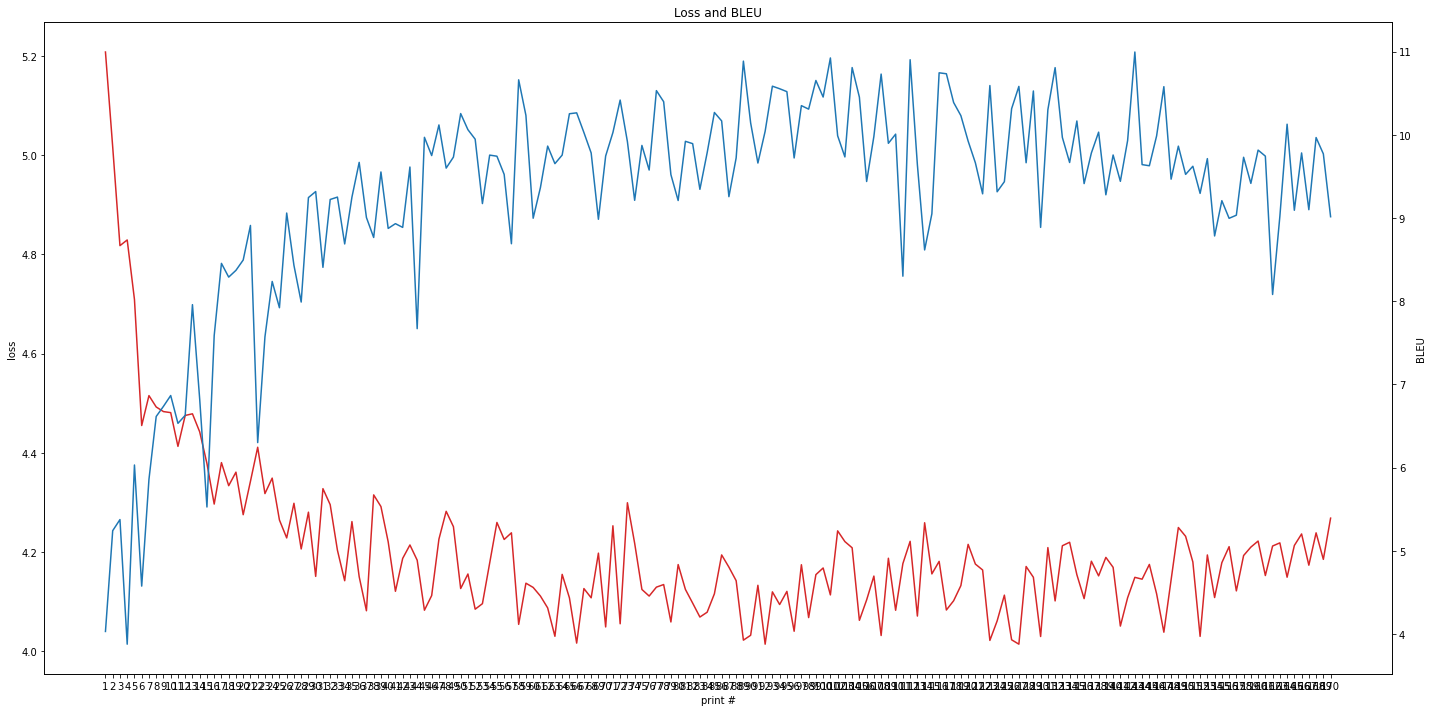

Streaming output truncated to the last 5000 lines.
Input      : le parlement marque son accord
Target     : parliament gave its assent
Translate  : parliament gave the president

18137 / 19135
Input      : qui souhaite intervenir pour defendre cette proposition
Target     : who wishes to speak in favour of this proposal
Translate  : what are we this

18138 / 19135
Input      : le parlement approuve la demande
Target     : parliament approved the request
Translate  : parliament adopted the resolution

18139 / 19135
Input      : il s agit des demandes suivantes
Target     : these requests are as follows
Translate  : the this is not enough

18140 / 19135
Input      : il est age
Target     : he is an old man
Translate  : the is is take place

18141 / 19135
Input      : pourquoi estce urgent
Target     : why is this urgent
Translate  : you have done

18142 / 19135
Input      : cest tout ce que je tiens a dire
Target     : my case rests there
Translate  : we therefore voted against this repo

In [ ]:
import os
import time
import math
import random
import numpy as np

import torch
import torch.nn as nn
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# reload sentences
input_sen, target_sen = load_sentence()

# build dictionaries
input_w2i, input_i2w = build_dictionary(input_sen)
target_w2i, target_i2w = build_dictionary(target_sen)

# parameters
ratio_train_test_split = 0.9
ratio_train_validation_split = 0.99
teacher_forcing_ratio = 0.5
input_size = len(input_w2i)
output_size = len(target_w2i)
embedding_size = 300
hidden_size = 200
num_epoch = 1
max_length = 10

# split the train and test sets
input_sen_tr, input_sen_te, target_sen_tr, target_sen_te = train_test_split(input_sen,target_sen,train_ratio=ratio_train_test_split,shuffle_sen=False,test_type="test")

# obtain the FastText embedding weights
prepare_encoder_weights = PreparePretrainedWeight(input_w2i,input_i2w,embedding_size,fasttext_directory_path="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/",lang_type="fr", rebuild_wordvector=False)
emb_weights_encoder = prepare_encoder_weights.generate_emb_weights()
prepare_decoder_weights = PreparePretrainedWeight(target_w2i,target_i2w,embedding_size,fasttext_directory_path="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/",lang_type="en", rebuild_wordvector=False)
emb_weights_decoder = prepare_decoder_weights.generate_emb_weights()
print("Pretrained weights for embedding layer obtained!")

# instantiate models
model_encoder = RNNEncoder(input_size = input_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = emb_weights_encoder).to(device)
model_decoder= RNNDecoder(output_size = output_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = emb_weights_decoder).to(device)

# training
loss, bleu = train(input_w2i, input_sen_tr, target_w2i, target_sen_tr, model_encoder, model_decoder, model_save_at="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/", \
             model_type="rnn", num_epoch=num_epoch, print_interval=1000, learning_rate=1e-2, \
             train_ratio=ratio_train_validation_split, max_length=max_length, continue_training=False, shuffle_sen=True)

# plot the loss and BLEU
plot_loss_bleu(loss, bleu, 20, 10)

# test after training
evaluate(input_w2i, input_i2w, input_sen_te, target_w2i, target_i2w, target_sen_te, model_encoder, model_decoder, max_length=10, model_type="rnn", verbose=True)

###4.1.2 2nd run - 1 epoch - continue training - learning rate = 1e-3 

In [ ]:
import os
import time
import math
import random
import numpy as np

import torch
import torch.nn as nn
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# reload sentences
input_sen, target_sen = load_sentence()

# build dictionaries
input_w2i, input_i2w = build_dictionary(input_sen)
target_w2i, target_i2w = build_dictionary(target_sen)

# parameters
ratio_train_test_split = 0.9
ratio_train_validation_split = 0.99
teacher_forcing_ratio = 0.5
input_size = len(input_w2i)
output_size = len(target_w2i)
embedding_size = 300
hidden_size = 200
num_epoch = 1
max_length = 10

# split the train and test sets
input_sen_tr, input_sen_te, target_sen_tr, target_sen_te = train_test_split(input_sen,target_sen,train_ratio=ratio_train_test_split,shuffle_sen=False,test_type="test")

# obtain the FastText embedding weights
prepare_encoder_weights = PreparePretrainedWeight(input_w2i,input_i2w,embedding_size,fasttext_directory_path="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/",lang_type="fr", rebuild_wordvector=False)
emb_weights_encoder = prepare_encoder_weights.generate_emb_weights()
prepare_decoder_weights = PreparePretrainedWeight(target_w2i,target_i2w,embedding_size,fasttext_directory_path="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/",lang_type="en", rebuild_wordvector=False)
emb_weights_decoder = prepare_decoder_weights.generate_emb_weights()
print("Pretrained weights for embedding layer obtained!")

# instantiate models
model_encoder = RNNEncoder(input_size = input_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = emb_weights_encoder).to(device)
model_decoder= RNNDecoder(output_size = output_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = emb_weights_decoder).to(device)

# training
loss, bleu = train(input_w2i, input_sen_tr, target_w2i, target_sen_tr, model_encoder, model_decoder, model_save_at="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/", \
             model_type="rnn", num_epoch=num_epoch, print_interval=1000, learning_rate=1e-3, \
             train_ratio=ratio_train_validation_split, max_length=max_length, continue_training=True, shuffle_sen=True)

# plot the loss and BLEU
plot_loss_bleu(loss, bleu, 20, 10)

# test after training
evaluate(input_w2i, input_i2w, input_sen_te, target_w2i, target_i2w, target_sen_te, model_encoder, model_decoder, max_length=10, model_type="rnn", verbose=True)

###4.1.3 3rd run - 1 epoch - continue training - learning rate = 1e-4

In [ ]:
import os
import time
import math
import random
import numpy as np

import torch
import torch.nn as nn
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# reload sentences
input_sen, target_sen = load_sentence()

# build dictionaries
input_w2i, input_i2w = build_dictionary(input_sen)
target_w2i, target_i2w = build_dictionary(target_sen)

# parameters
ratio_train_test_split = 0.9
ratio_train_validation_split = 0.99
teacher_forcing_ratio = 0.5
input_size = len(input_w2i)
output_size = len(target_w2i)
embedding_size = 300
hidden_size = 200
num_epoch = 1
max_length = 10

# split the train and test sets
input_sen_tr, input_sen_te, target_sen_tr, target_sen_te = train_test_split(input_sen,target_sen,train_ratio=ratio_train_test_split,shuffle_sen=False,test_type="test")

# obtain the FastText embedding weights
prepare_encoder_weights = PreparePretrainedWeight(input_w2i,input_i2w,embedding_size,fasttext_directory_path="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/",lang_type="fr", rebuild_wordvector=False)
emb_weights_encoder = prepare_encoder_weights.generate_emb_weights()
prepare_decoder_weights = PreparePretrainedWeight(target_w2i,target_i2w,embedding_size,fasttext_directory_path="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/",lang_type="en", rebuild_wordvector=False)
emb_weights_decoder = prepare_decoder_weights.generate_emb_weights()
print("Pretrained weights for embedding layer obtained!")

# instantiate models
model_encoder = RNNEncoder(input_size = input_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = emb_weights_encoder).to(device)
model_decoder= RNNDecoder(output_size = output_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = emb_weights_decoder).to(device)

# training
loss, bleu = train(input_w2i, input_sen_tr, target_w2i, target_sen_tr, model_encoder, model_decoder, model_save_at="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/", \
             model_type="rnn", num_epoch=num_epoch, print_interval=1000, learning_rate=1e-4, \
             train_ratio=ratio_train_validation_split, max_length=max_length, continue_training=True, shuffle_sen=True)

# plot the loss and BLEU
plot_loss_bleu(loss, bleu, 20, 10)

# test after training
evaluate(input_w2i, input_i2w, input_sen_te, target_w2i, target_i2w, target_sen_te, model_encoder, model_decoder, max_length=10, model_type="rnn", verbose=True)

## 4.2 Evaluate Only - RNN Encoder/Decoder

In [ ]:
import numpy as np

import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# reload sentences
input_sen, target_sen = load_sentence()

# build dictionaries
input_w2i, input_i2w = build_dictionary(input_sen)
target_w2i, target_i2w = build_dictionary(target_sen)

# parameters
ratio_train_test_split = 0.9
input_size = len(input_w2i)
output_size = len(target_w2i)
embedding_size = 300
hidden_size = 200
max_length = 10

# split the train and test sets
_, input_sen_te, _, target_sen_te = train_test_split(input_sen,target_sen,train_ratio=ratio_train_test_split,shuffle_sen=False,test_type="test")

# obtain the FastText embedding weights
prepare_encoder_weights = PreparePretrainedWeight(input_w2i,input_i2w,embedding_size,fasttext_directory_path="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/",lang_type="fr", rebuild_wordvector=False)
emb_weights_encoder = prepare_encoder_weights.generate_emb_weights()
prepare_decoder_weights = PreparePretrainedWeight(target_w2i,target_i2w,embedding_size,fasttext_directory_path="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/",lang_type="en", rebuild_wordvector=False)
emb_weights_decoder = prepare_decoder_weights.generate_emb_weights()
print("Pretrained weights for embedding layer obtained!")

# instantiate models
model_encoder = RNNEncoder(input_size = input_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = emb_weights_encoder).to(device)
model_decoder= RNNDecoder(output_size = output_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = emb_weights_decoder).to(device)

# load saved models
model_encoder.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/model_encoder_rnn.pth"))
model_encoder.eval()
model_decoder.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/model_decoder_rnn.pth"))
model_decoder.eval()

# evaluate
evaluate(input_w2i, input_i2w, input_sen_te, target_w2i, target_i2w, target_sen_te, model_encoder, model_decoder, max_length=10, model_type="rnn", verbose=True)

##4.3 Train/Evaluate - LSTM Encoder/Decoder

###4.3.1 1st run - 1 epoch - learning rate = 1e-2

/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/input_sen.pkl loaded
/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/target_sen.pkl loaded
172211 sentences in the train set. 19135 sentences in the test set. The test set will be reserved for evaluation.
Pretrained weights at /content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/cc.fr.300.vec.pkl loaded
Pretrained weights at /content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/cc.en.300.vec.pkl loaded
Pretrained weights for embedding layer obtained!
LSTM Encoder embedding layer initialized with the FastText weights:
 tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0425, -0.0035,  0.0066,  ...,  0.0714, -0.0167,  0.0370],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0186, -0.0930,  0.0828,  ..., -0.0615,  0.0133,  0.0909],
        [-0.0340, -0.0118,  0.01

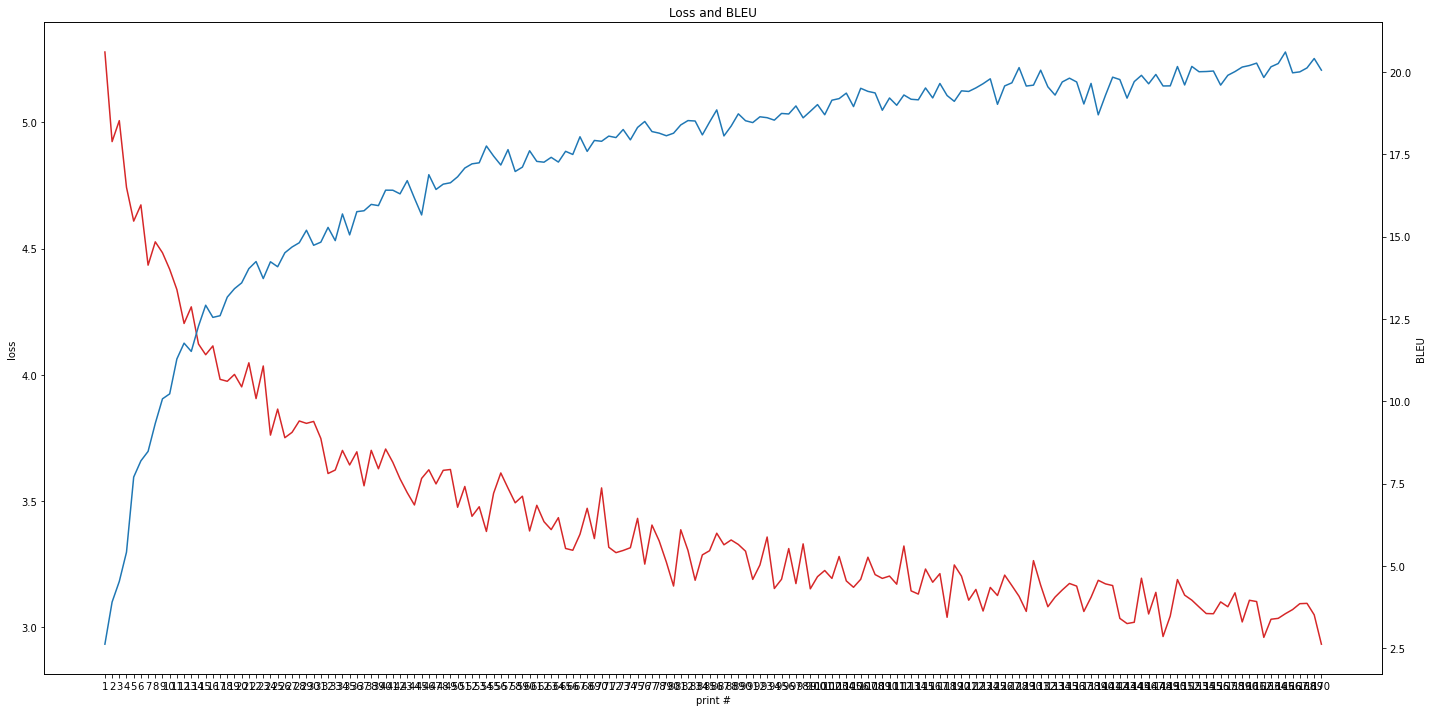

Streaming output truncated to the last 5000 lines.
Input      : le parlement marque son accord
Target     : parliament gave its assent
Translate  : parliament approved the request

18137 / 19135
Input      : qui souhaite intervenir pour defendre cette proposition
Target     : who wishes to speak in favour of this proposal
Translate  : who for the proposal for this proposal

18138 / 19135
Input      : le parlement approuve la demande
Target     : parliament approved the request
Translate  : parliament approved the request

18139 / 19135
Input      : il s agit des demandes suivantes
Target     : these requests are as follows
Translate  : we have to of

18140 / 19135
Input      : il est age
Target     : he is an old man
Translate  : it is is

18141 / 19135
Input      : pourquoi estce urgent
Target     : why is this urgent
Translate  : why is this

18142 / 19135
Input      : cest tout ce que je tiens a dire
Target     : my case rests there
Translate  : that is all i i say

18143 / 19135
In

In [ ]:
import os
import time
import math
import random
import numpy as np

import torch
import torch.nn as nn
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# reload sentences
input_sen, target_sen = load_sentence()

# build dictionaries
input_w2i, input_i2w = build_dictionary(input_sen)
target_w2i, target_i2w = build_dictionary(target_sen)

# parameters
ratio_train_test_split = 0.9
ratio_train_validation_split = 0.99
teacher_forcing_ratio = 0.5
input_size = len(input_w2i)
output_size = len(target_w2i)
embedding_size = 300
hidden_size = 200
num_epoch = 1
max_length = 10

# split the train and test sets
input_sen_tr, input_sen_te, target_sen_tr, target_sen_te = train_test_split(input_sen,target_sen,train_ratio=ratio_train_test_split,shuffle_sen=False,test_type="test")

# obtain the FastText embedding weights
prepare_encoder_weights = PreparePretrainedWeight(input_w2i,input_i2w,embedding_size,fasttext_directory_path="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/",lang_type="fr", rebuild_wordvector=False)
emb_weights_encoder = prepare_encoder_weights.generate_emb_weights()
prepare_decoder_weights = PreparePretrainedWeight(target_w2i,target_i2w,embedding_size,fasttext_directory_path="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/",lang_type="en", rebuild_wordvector=False)
emb_weights_decoder = prepare_decoder_weights.generate_emb_weights()
print("Pretrained weights for embedding layer obtained!")

# instantiate models
model_encoder = LSTMEncoder(input_size = input_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = emb_weights_encoder).to(device)
model_decoder= LSTMDecoder(output_size = output_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = emb_weights_decoder).to(device)

# training
loss, bleu = train(input_w2i, input_sen_tr, target_w2i, target_sen_tr, model_encoder, model_decoder, model_save_at="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/", \
             model_type="lstm", num_epoch=num_epoch, print_interval=1000, learning_rate=1e-2, \
             train_ratio=ratio_train_validation_split, max_length=max_length, continue_training=False, shuffle_sen=True)

# plot the loss and BLEU
plot_loss_bleu(loss, bleu, 20, 10)

# test after training
evaluate(input_w2i, input_i2w, input_sen_te, target_w2i, target_i2w, target_sen_te, model_encoder, model_decoder, max_length=10, model_type="lstm", verbose=True)

###4.3.2 2nd run - 1 epoch - continue training - learning rate = 1e-3

In [ ]:
import os
import time
import math
import random
import numpy as np

import torch
import torch.nn as nn
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# reload sentences
input_sen, target_sen = load_sentence()

# build dictionaries
input_w2i, input_i2w = build_dictionary(input_sen)
target_w2i, target_i2w = build_dictionary(target_sen)

# parameters
ratio_train_test_split = 0.9
ratio_train_validation_split = 0.99
teacher_forcing_ratio = 0.5
input_size = len(input_w2i)
output_size = len(target_w2i)
embedding_size = 300
hidden_size = 200
num_epoch = 1
max_length = 10

# split the train and test sets
input_sen_tr, input_sen_te, target_sen_tr, target_sen_te = train_test_split(input_sen,target_sen,train_ratio=ratio_train_test_split,shuffle_sen=False,test_type="test")

# obtain the FastText embedding weights
prepare_encoder_weights = PreparePretrainedWeight(input_w2i,input_i2w,embedding_size,fasttext_directory_path="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/",lang_type="fr", rebuild_wordvector=False)
emb_weights_encoder = prepare_encoder_weights.generate_emb_weights()
prepare_decoder_weights = PreparePretrainedWeight(target_w2i,target_i2w,embedding_size,fasttext_directory_path="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/",lang_type="en", rebuild_wordvector=False)
emb_weights_decoder = prepare_decoder_weights.generate_emb_weights()
print("Pretrained weights for embedding layer obtained!")

# instantiate models
model_encoder = LSTMEncoder(input_size = input_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = emb_weights_encoder).to(device)
model_decoder= LSTMDecoder(output_size = output_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = emb_weights_decoder).to(device)

# training
loss, bleu = train(input_w2i, input_sen_tr, target_w2i, target_sen_tr, model_encoder, model_decoder, model_save_at="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/", \
             model_type="lstm", num_epoch=num_epoch, print_interval=1000, learning_rate=1e-3, \
             train_ratio=ratio_train_validation_split, max_length=max_length, continue_training=True, shuffle_sen=True)

# plot the loss and BLEU
plot_loss_bleu(loss, bleu, 20, 10)

# test after training
evaluate(input_w2i, input_i2w, input_sen_te, target_w2i, target_i2w, target_sen_te, model_encoder, model_decoder, max_length=10, model_type="lstm", verbose=True)

###4.3.3 3rd run - 1 epoch - continue training - learning rate = 1e-4

In [ ]:
import os
import time
import math
import random
import numpy as np

import torch
import torch.nn as nn
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# reload sentences
input_sen, target_sen = load_sentence()

# build dictionaries
input_w2i, input_i2w = build_dictionary(input_sen)
target_w2i, target_i2w = build_dictionary(target_sen)

# parameters
ratio_train_test_split = 0.9
ratio_train_validation_split = 0.99
teacher_forcing_ratio = 0.5
input_size = len(input_w2i)
output_size = len(target_w2i)
embedding_size = 300
hidden_size = 200
num_epoch = 1
max_length = 10

# split the train and test sets
input_sen_tr, input_sen_te, target_sen_tr, target_sen_te = train_test_split(input_sen,target_sen,train_ratio=ratio_train_test_split,shuffle_sen=False,test_type="test")

# obtain the FastText embedding weights
prepare_encoder_weights = PreparePretrainedWeight(input_w2i,input_i2w,embedding_size,fasttext_directory_path="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/",lang_type="fr", rebuild_wordvector=False)
emb_weights_encoder = prepare_encoder_weights.generate_emb_weights()
prepare_decoder_weights = PreparePretrainedWeight(target_w2i,target_i2w,embedding_size,fasttext_directory_path="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/",lang_type="en", rebuild_wordvector=False)
emb_weights_decoder = prepare_decoder_weights.generate_emb_weights()
print("Pretrained weights for embedding layer obtained!")

# instantiate models
model_encoder = LSTMEncoder(input_size = input_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = emb_weights_encoder).to(device)
model_decoder= LSTMDecoder(output_size = output_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = emb_weights_decoder).to(device)

# training
loss, bleu = train(input_w2i, input_sen_tr, target_w2i, target_sen_tr, model_encoder, model_decoder, model_save_at="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/", \
             model_type="lstm", num_epoch=num_epoch, print_interval=1000, learning_rate=1e-4, \
             train_ratio=ratio_train_validation_split, max_length=max_length, continue_training=True, shuffle_sen=True)

# plot the loss and BLEU
plot_loss_bleu(loss, bleu, 20, 10)

# test after training
evaluate(input_w2i, input_i2w, input_sen_te, target_w2i, target_i2w, target_sen_te, model_encoder, model_decoder, max_length=10, model_type="lstm", verbose=True)

##4.4 Evaluate Only - LSTM Encoder/Decoder

In [ ]:
import numpy as np

import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# reload sentences
input_sen, target_sen = load_sentence()

# build dictionaries
input_w2i, input_i2w = build_dictionary(input_sen)
target_w2i, target_i2w = build_dictionary(target_sen)

# parameters
ratio_train_test_split = 0.9
input_size = len(input_w2i)
output_size = len(target_w2i)
embedding_size = 300
hidden_size = 200
max_length = 10

# split the train and test sets
_, input_sen_te, _, target_sen_te = train_test_split(input_sen,target_sen,train_ratio=ratio_train_test_split,shuffle_sen=False,test_type="test")

# obtain the FastText embedding weights
prepare_encoder_weights = PreparePretrainedWeight(input_w2i,input_i2w,embedding_size,fasttext_directory_path="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/",lang_type="fr", rebuild_wordvector=False)
emb_weights_encoder = prepare_encoder_weights.generate_emb_weights()
prepare_decoder_weights = PreparePretrainedWeight(target_w2i,target_i2w,embedding_size,fasttext_directory_path="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/",lang_type="en", rebuild_wordvector=False)
emb_weights_decoder = prepare_decoder_weights.generate_emb_weights()
print("Pretrained weights for embedding layer obtained!")

# instantiate models
model_encoder = LSTMEncoder(input_size = input_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = emb_weights_encoder).to(device)
model_decoder= LSTMDecoder(output_size = output_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = emb_weights_decoder).to(device)

# load saved models
model_encoder.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/model_encoder_lstm.pth"))
model_encoder.eval()
model_decoder.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/model_decoder_lstm.pth"))
model_decoder.eval()

# evaluate
evaluate(input_w2i, input_i2w, input_sen_te, target_w2i, target_i2w, target_sen_te, model_encoder, model_decoder, max_length=10, model_type="lstm", verbose=True)

##4.5 Train/Evaluate - GRU Encoder/Decoder

###4.5.1 1st run - 1 epoch - learning rate = 1e-2

/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/input_sen.pkl loaded
/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/target_sen.pkl loaded
172211 sentences in the train set. 19135 sentences in the test set. The test set will be reserved for evaluation.
Pretrained weights at /content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/cc.fr.300.vec.pkl loaded
Pretrained weights at /content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/cc.en.300.vec.pkl loaded
Pretrained weights for embedding layer obtained!
GRU Encoder embedding layer initialized with the FastText weights:
 tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0425, -0.0035,  0.0066,  ...,  0.0714, -0.0167,  0.0370],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0186, -0.0930,  0.0828,  ..., -0.0615,  0.0133,  0.0909],
        [-0.0340, -0.0118,  0.017

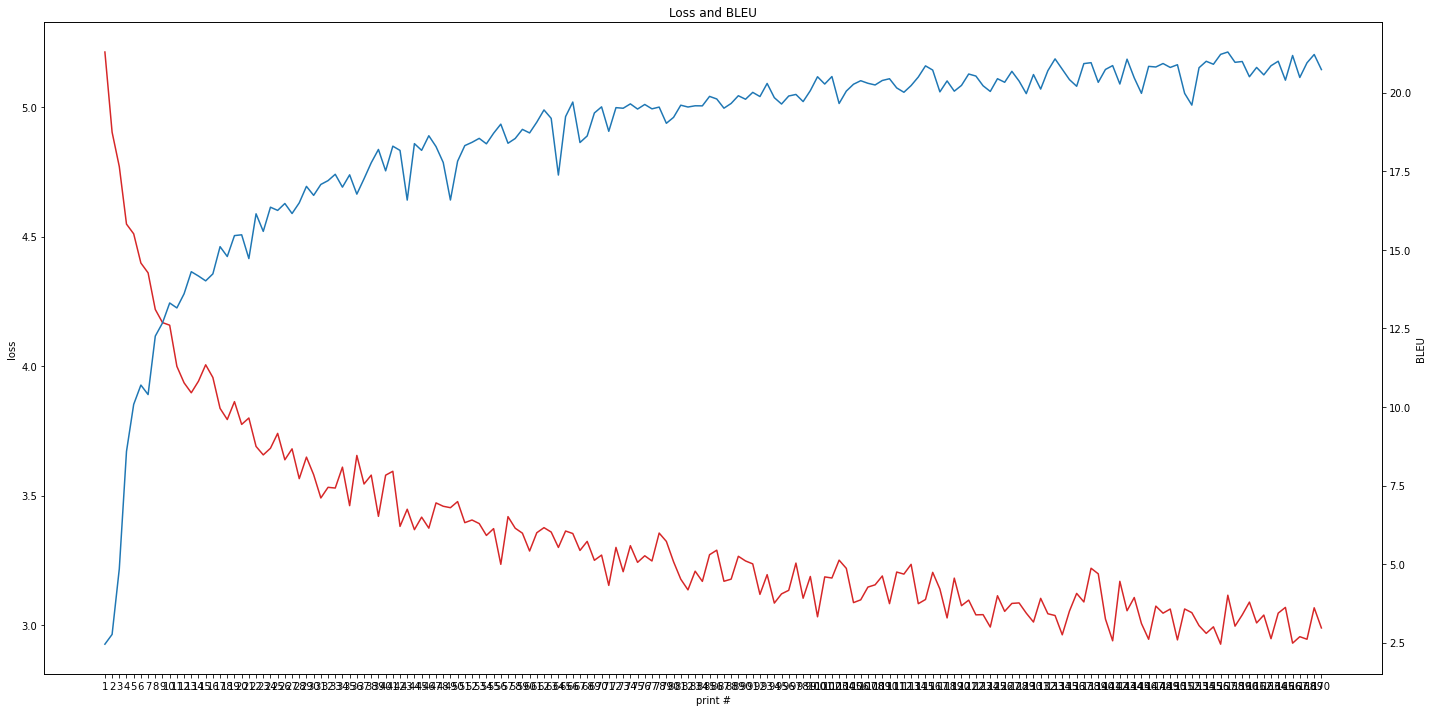

Streaming output truncated to the last 5000 lines.
Input      : le parlement marque son accord
Target     : parliament gave its assent
Translate  : parliament gave its assent

18137 / 19135
Input      : qui souhaite intervenir pour defendre cette proposition
Target     : who wishes to speak in favour of this proposal
Translate  : who would be against for for

18138 / 19135
Input      : le parlement approuve la demande
Target     : parliament approved the request
Translate  : parliament approved the request

18139 / 19135
Input      : il s agit des demandes suivantes
Target     : these requests are as follows
Translate  : it is the to

18140 / 19135
Input      : il est age
Target     : he is an old man
Translate  : it is the to

18141 / 19135
Input      : pourquoi estce urgent
Target     : why is this urgent
Translate  : why is that

18142 / 19135
Input      : cest tout ce que je tiens a dire
Target     : my case rests there
Translate  : that is what i say i say

18143 / 19135
Input    

In [ ]:
import os
import time
import math
import random
import numpy as np

import torch
import torch.nn as nn
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# reload sentences
input_sen, target_sen = load_sentence()

# build dictionaries
input_w2i, input_i2w = build_dictionary(input_sen)
target_w2i, target_i2w = build_dictionary(target_sen)

# parameters
ratio_train_test_split = 0.9
ratio_train_validation_split = 0.99
teacher_forcing_ratio = 0.5
input_size = len(input_w2i)
output_size = len(target_w2i)
embedding_size = 300
hidden_size = 200
num_epoch = 1
max_length = 10

# split the train and test sets
input_sen_tr, input_sen_te, target_sen_tr, target_sen_te = train_test_split(input_sen,target_sen,train_ratio=ratio_train_test_split,shuffle_sen=False,test_type="test")

# obtain the FastText embedding weights
prepare_encoder_weights = PreparePretrainedWeight(input_w2i,input_i2w,embedding_size,fasttext_directory_path="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/",lang_type="fr", rebuild_wordvector=False)
emb_weights_encoder = prepare_encoder_weights.generate_emb_weights()
prepare_decoder_weights = PreparePretrainedWeight(target_w2i,target_i2w,embedding_size,fasttext_directory_path="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/",lang_type="en", rebuild_wordvector=False)
emb_weights_decoder = prepare_decoder_weights.generate_emb_weights()
print("Pretrained weights for embedding layer obtained!")

# instantiate models
model_encoder = GRUEncoder(input_size = input_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = emb_weights_encoder).to(device)
model_decoder= GRUDecoder(output_size = output_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = emb_weights_decoder).to(device)

# training
loss, bleu = train(input_w2i, input_sen_tr, target_w2i, target_sen_tr, model_encoder, model_decoder, model_save_at="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/", \
             model_type="gru", num_epoch=num_epoch, print_interval=1000, learning_rate=1e-2, \
             train_ratio=ratio_train_validation_split, max_length=max_length, continue_training=False, shuffle_sen=True)

# plot the loss and BLEU
plot_loss_bleu(loss, bleu, 20, 10)

# test after training
evaluate(input_w2i, input_i2w, input_sen_te, target_w2i, target_i2w, target_sen_te, model_encoder, model_decoder, max_length=10, model_type="gru", verbose=True)

###4.5.2 2nd run - 1 epoch - continue training - learning rate = 1e-3

In [ ]:
import os
import time
import math
import random
import numpy as np

import torch
import torch.nn as nn
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# reload sentences
input_sen, target_sen = load_sentence()

# build dictionaries
input_w2i, input_i2w = build_dictionary(input_sen)
target_w2i, target_i2w = build_dictionary(target_sen)

# parameters
ratio_train_test_split = 0.9
ratio_train_validation_split = 0.99
teacher_forcing_ratio = 0.5
input_size = len(input_w2i)
output_size = len(target_w2i)
embedding_size = 300
hidden_size = 200
num_epoch = 1
max_length = 10

# split the train and test sets
input_sen_tr, input_sen_te, target_sen_tr, target_sen_te = train_test_split(input_sen,target_sen,train_ratio=ratio_train_test_split,shuffle_sen=False,test_type="test")

# obtain the FastText embedding weights
prepare_encoder_weights = PreparePretrainedWeight(input_w2i,input_i2w,embedding_size,fasttext_directory_path="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/",lang_type="fr", rebuild_wordvector=False)
emb_weights_encoder = prepare_encoder_weights.generate_emb_weights()
prepare_decoder_weights = PreparePretrainedWeight(target_w2i,target_i2w,embedding_size,fasttext_directory_path="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/",lang_type="en", rebuild_wordvector=False)
emb_weights_decoder = prepare_decoder_weights.generate_emb_weights()
print("Pretrained weights for embedding layer obtained!")

# instantiate models
model_encoder = GRUEncoder(input_size = input_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = emb_weights_encoder).to(device)
model_decoder= GRUDecoder(output_size = output_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = emb_weights_decoder).to(device)

# training
loss, bleu = train(input_w2i, input_sen_tr, target_w2i, target_sen_tr, model_encoder, model_decoder, model_save_at="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/", \
             model_type="gru", num_epoch=num_epoch, print_interval=1000, learning_rate=1e-3, \
             train_ratio=ratio_train_validation_split, max_length=max_length, continue_training=True, shuffle_sen=True)

# plot the loss and BLEU
plot_loss_bleu(loss, bleu, 20, 10)

# test after training
evaluate(input_w2i, input_i2w, input_sen_te, target_w2i, target_i2w, target_sen_te, model_encoder, model_decoder, max_length=10, model_type="gru", verbose=True)

###4.5.3 3rd run - 1 epoch - continue training - learning rate = 1e-4

In [ ]:
import os
import time
import math
import random
import numpy as np

import torch
import torch.nn as nn
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# reload sentences
input_sen, target_sen = load_sentence()

# build dictionaries
input_w2i, input_i2w = build_dictionary(input_sen)
target_w2i, target_i2w = build_dictionary(target_sen)

# parameters
ratio_train_test_split = 0.9
ratio_train_validation_split = 0.99
teacher_forcing_ratio = 0.5
input_size = len(input_w2i)
output_size = len(target_w2i)
embedding_size = 300
hidden_size = 200
num_epoch = 1
max_length = 10

# split the train and test sets
input_sen_tr, input_sen_te, target_sen_tr, target_sen_te = train_test_split(input_sen,target_sen,train_ratio=ratio_train_test_split,shuffle_sen=False,test_type="test")

# obtain the FastText embedding weights
prepare_encoder_weights = PreparePretrainedWeight(input_w2i,input_i2w,embedding_size,fasttext_directory_path="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/",lang_type="fr", rebuild_wordvector=False)
emb_weights_encoder = prepare_encoder_weights.generate_emb_weights()
prepare_decoder_weights = PreparePretrainedWeight(target_w2i,target_i2w,embedding_size,fasttext_directory_path="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/",lang_type="en", rebuild_wordvector=False)
emb_weights_decoder = prepare_decoder_weights.generate_emb_weights()
print("Pretrained weights for embedding layer obtained!")

# instantiate models
model_encoder = GRUEncoder(input_size = input_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = emb_weights_encoder).to(device)
model_decoder= GRUDecoder(output_size = output_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = emb_weights_decoder).to(device)

# training
loss, bleu = train(input_w2i, input_sen_tr, target_w2i, target_sen_tr, model_encoder, model_decoder, model_save_at="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/", \
             model_type="gru", num_epoch=num_epoch, print_interval=1000, learning_rate=1e-4, \
             train_ratio=ratio_train_validation_split, max_length=max_length, continue_training=True, shuffle_sen=True)

# plot the loss and BLEU
plot_loss_bleu(loss, bleu, 20, 10)

# test after training
evaluate(input_w2i, input_i2w, input_sen_te, target_w2i, target_i2w, target_sen_te, model_encoder, model_decoder, max_length=10, model_type="gru", verbose=True)

##4.6 Evaluate Only - GRU Encoder/Decoder

In [ ]:
import numpy as np

import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# reload sentences
input_sen, target_sen = load_sentence()

# build dictionaries
input_w2i, input_i2w = build_dictionary(input_sen)
target_w2i, target_i2w = build_dictionary(target_sen)

# parameters
ratio_train_test_split = 0.9
input_size = len(input_w2i)
output_size = len(target_w2i)
embedding_size = 300
hidden_size = 200
max_length = 10

# split the train and test sets
_, input_sen_te, _, target_sen_te = train_test_split(input_sen,target_sen,train_ratio=ratio_train_test_split,shuffle_sen=False,test_type="test")

# obtain the FastText embedding weights
prepare_encoder_weights = PreparePretrainedWeight(input_w2i,input_i2w,embedding_size,fasttext_directory_path="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/",lang_type="fr", rebuild_wordvector=False)
emb_weights_encoder = prepare_encoder_weights.generate_emb_weights()
prepare_decoder_weights = PreparePretrainedWeight(target_w2i,target_i2w,embedding_size,fasttext_directory_path="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/",lang_type="en", rebuild_wordvector=False)
emb_weights_decoder = prepare_decoder_weights.generate_emb_weights()
print("Pretrained weights for embedding layer obtained!")

# instantiate models
model_encoder = GRUEncoder(input_size = input_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = emb_weights_encoder).to(device)
model_decoder= GRUDecoder(output_size = output_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = emb_weights_decoder).to(device)

# load saved models
model_encoder.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/model_encoder_gru.pth"))
model_encoder.eval()
model_decoder.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/model_decoder_gru.pth"))
model_decoder.eval()

# evaluate
evaluate(input_w2i, input_i2w, input_sen_te, target_w2i, target_i2w, target_sen_te, model_encoder, model_decoder, max_length=10, model_type="gru", verbose=True)

##4.7 Train - GRU Encoder/Attention-Decoder

###4.7.1 1st run - 1 epoch - learning rate = 1e-2

In [ ]:
import os
import time
import math
import random
import numpy as np

import torch
import torch.nn as nn
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# reload sentences
input_sen, target_sen = load_sentence()

# build dictionaries
input_w2i, input_i2w = build_dictionary(input_sen)
target_w2i, target_i2w = build_dictionary(target_sen)

# parameters
ratio_train_test_split = 0.9
teacher_forcing_ratio = 0.5
input_size = len(input_w2i)
output_size = len(target_w2i)
embedding_size = 300
hidden_size = 300
num_epoch = 1
max_length = 10
ratio_train_validation_split = 0.99

# split the train and test sets
input_sen_tr, input_sen_te, target_sen_tr, target_sen_te = train_test_split(input_sen,target_sen,train_ratio=ratio_train_test_split,shuffle_sen=False,test_type="test")


# obtain the FastText embedding weights
prepare_encoder_weights = PreparePretrainedWeight(input_w2i,input_i2w,embedding_size,fasttext_directory_path="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/",lang_type="fr", rebuild_wordvector=False)
emb_weights_encoder = prepare_encoder_weights.generate_emb_weights()
prepare_decoder_weights = PreparePretrainedWeight(target_w2i,target_i2w,embedding_size,fasttext_directory_path="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/",lang_type="en", rebuild_wordvector=False)
emb_weights_decoder = prepare_decoder_weights.generate_emb_weights()
print("Pretrained weights for embedding layer obtained!")

# instantiate models
model_encoder = GRUEncoder(input_size = input_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = emb_weights_encoder).to(device)
model_decoder= GRUAttnDecoder(output_size = output_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = emb_weights_decoder).to(device)

# training
loss, bleu = train(input_w2i, input_sen_tr, target_w2i, target_sen_tr, model_encoder, model_decoder, model_save_at="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/", \
             model_type="gru_attention", num_epoch=num_epoch, print_interval=1000, learning_rate=1e-2, \
             train_ratio=ratio_train_validation_split, max_length=max_length, continue_training=False, shuffle_sen=True)

# plot the loss and BLEU
plot_loss_bleu(loss, bleu, 20, 10)

# test after training
evaluate(input_w2i, input_i2w, input_sen_te, target_w2i, target_i2w, target_sen_te, model_encoder, model_decoder, max_length=10, model_type="gru_attention", verbose=True)

###4.7.2 2nd run - 1 epoch - learning rate = 1e-3

In [ ]:
import os
import time
import math
import random
import numpy as np

import torch
import torch.nn as nn
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# reload sentences
input_sen, target_sen = load_sentence()

# build dictionaries
input_w2i, input_i2w = build_dictionary(input_sen)
target_w2i, target_i2w = build_dictionary(target_sen)

# parameters
ratio_train_test_split = 0.9
teacher_forcing_ratio = 0.5
input_size = len(input_w2i)
output_size = len(target_w2i)
embedding_size = 300
hidden_size = 300
num_epoch = 1
max_length = 10
ratio_train_validation_split = 0.99

# split the train and test sets
input_sen_tr, input_sen_te, target_sen_tr, target_sen_te = train_test_split(input_sen,target_sen,train_ratio=ratio_train_test_split,shuffle_sen=False,test_type="test")


# obtain the FastText embedding weights
prepare_encoder_weights = PreparePretrainedWeight(input_w2i,input_i2w,embedding_size,fasttext_directory_path="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/",lang_type="fr", rebuild_wordvector=False)
emb_weights_encoder = prepare_encoder_weights.generate_emb_weights()
prepare_decoder_weights = PreparePretrainedWeight(target_w2i,target_i2w,embedding_size,fasttext_directory_path="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/",lang_type="en", rebuild_wordvector=False)
emb_weights_decoder = prepare_decoder_weights.generate_emb_weights()
print("Pretrained weights for embedding layer obtained!")

# instantiate models
model_encoder = GRUEncoder(input_size = input_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = emb_weights_encoder).to(device)
model_decoder= GRUAttnDecoder(output_size = output_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = emb_weights_decoder).to(device)

# training
loss, bleu = train(input_w2i, input_sen_tr, target_w2i, target_sen_tr, model_encoder, model_decoder, model_save_at="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/", \
             model_type="gru_attention", num_epoch=num_epoch, print_interval=1000, learning_rate=1e-3, \
             train_ratio=ratio_train_validation_split, max_length=max_length, continue_training=True, shuffle_sen=True)

# plot the loss and BLEU
plot_loss_bleu(loss, bleu, 20, 10)

# test after training
evaluate(input_w2i, input_i2w, input_sen_te, target_w2i, target_i2w, target_sen_te, model_encoder, model_decoder, max_length=10, model_type="gru_attention", verbose=True)

###4.7.3 3rd run - 1 epoch - learning rate = 1e-4

In [ ]:
import os
import time
import math
import random
import numpy as np

import torch
import torch.nn as nn
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# reload sentences
input_sen, target_sen = load_sentence()

# build dictionaries
input_w2i, input_i2w = build_dictionary(input_sen)
target_w2i, target_i2w = build_dictionary(target_sen)

# parameters
ratio_train_test_split = 0.9
teacher_forcing_ratio = 0.5
input_size = len(input_w2i)
output_size = len(target_w2i)
embedding_size = 300
hidden_size = 300
num_epoch = 1
max_length = 10
ratio_train_validation_split = 0.99

# split the train and test sets
input_sen_tr, input_sen_te, target_sen_tr, target_sen_te = train_test_split(input_sen,target_sen,train_ratio=ratio_train_test_split,shuffle_sen=False,test_type="test")


# obtain the FastText embedding weights
prepare_encoder_weights = PreparePretrainedWeight(input_w2i,input_i2w,embedding_size,fasttext_directory_path="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/",lang_type="fr", rebuild_wordvector=False)
emb_weights_encoder = prepare_encoder_weights.generate_emb_weights()
prepare_decoder_weights = PreparePretrainedWeight(target_w2i,target_i2w,embedding_size,fasttext_directory_path="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/",lang_type="en", rebuild_wordvector=False)
emb_weights_decoder = prepare_decoder_weights.generate_emb_weights()
print("Pretrained weights for embedding layer obtained!")

# instantiate models
model_encoder = GRUEncoder(input_size = input_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = emb_weights_encoder).to(device)
model_decoder= GRUAttnDecoder(output_size = output_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = emb_weights_decoder).to(device)

# training
loss, bleu = train(input_w2i, input_sen_tr, target_w2i, target_sen_tr, model_encoder, model_decoder, model_save_at="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/", \
             model_type="gru_attention", num_epoch=num_epoch, print_interval=1000, learning_rate=1e-4, \
             train_ratio=ratio_train_validation_split, max_length=max_length, continue_training=True, shuffle_sen=True)

# plot the loss and BLEU
plot_loss_bleu(loss, bleu, 20, 10)

# test after training
evaluate(input_w2i, input_i2w, input_sen_te, target_w2i, target_i2w, target_sen_te, model_encoder, model_decoder, max_length=10, model_type="gru_attention", verbose=True)

##4.8 Evaluate Only - GRU Encoder/Attention-Decoder

In [ ]:
import numpy as np

import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# reload sentences
input_sen, target_sen = load_sentence()

# build dictionaries
input_w2i, input_i2w = build_dictionary(input_sen)
target_w2i, target_i2w = build_dictionary(target_sen)

# parameters
ratio_train_test_split = 0.9
input_size = len(input_w2i)
output_size = len(target_w2i)
embedding_size = 300
hidden_size = 300
max_length = 10

# split the train and test sets
_, input_sen_te, _, target_sen_te = train_test_split(input_sen,target_sen,train_ratio=ratio_train_test_split,shuffle_sen=False,test_type="test")

# obtain the FastText embedding weights
prepare_encoder_weights = PreparePretrainedWeight(input_w2i,input_i2w,embedding_size,fasttext_directory_path="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/",lang_type="fr", rebuild_wordvector=False)
emb_weights_encoder = prepare_encoder_weights.generate_emb_weights()
prepare_decoder_weights = PreparePretrainedWeight(target_w2i,target_i2w,embedding_size,fasttext_directory_path="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/",lang_type="en", rebuild_wordvector=False)
emb_weights_decoder = prepare_decoder_weights.generate_emb_weights()
print("Pretrained weights for embedding layer obtained!")

# instantiate models
model_encoder = GRUEncoder(input_size = input_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = emb_weights_encoder).to(device)
model_decoder= GRUAttnDecoder(output_size = output_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = emb_weights_decoder).to(device)

# load saved models
model_encoder.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/model_encoder_gru_attention.pth"))
model_encoder.eval()
model_decoder.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/model_decoder_gru_attention.pth"))
model_decoder.eval()

# evaluate
evaluate(input_w2i, input_i2w, input_sen_te, target_w2i, target_i2w, target_sen_te, model_encoder, model_decoder, max_length=10, model_type="gru_attention", verbose=True)


##4.9 Train - GRU Encoder/Attention-Decoder without FastText weights loaded at the embedding layer

### 4.9.1 1st run - 1 epoch - learning rate = 1e-2

/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/input_sen.pkl loaded
/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/target_sen.pkl loaded
172211 sentences in the train set. 19135 sentences in the test set. The test set will be reserved for evaluation.
GRU Encoder embedding layer randomly initialized.
GRU Decoder with attention embedding layer randomly initialized.
sentences shuffled.
170488 sentences in the train set. 1723 sentences in the valiation set. The test set will be reserved for evaluation.
For 1 epochs, there are in total 170488 sentences for training.

Convert all the train sentences (input, target) to tensors...

training in progress ...
--------------------------------------------------------------------------------
step # 1000/170488  epoch # 1/1 learning rate: 0.01 average loss: 5.406390207756505 validation BLEU: 2.7172229272118376
step # 2000/170488  epoch # 1/1 learning rate: 0.01 average loss: 5.148761511593013 validation BLEU: 3.435334416373416

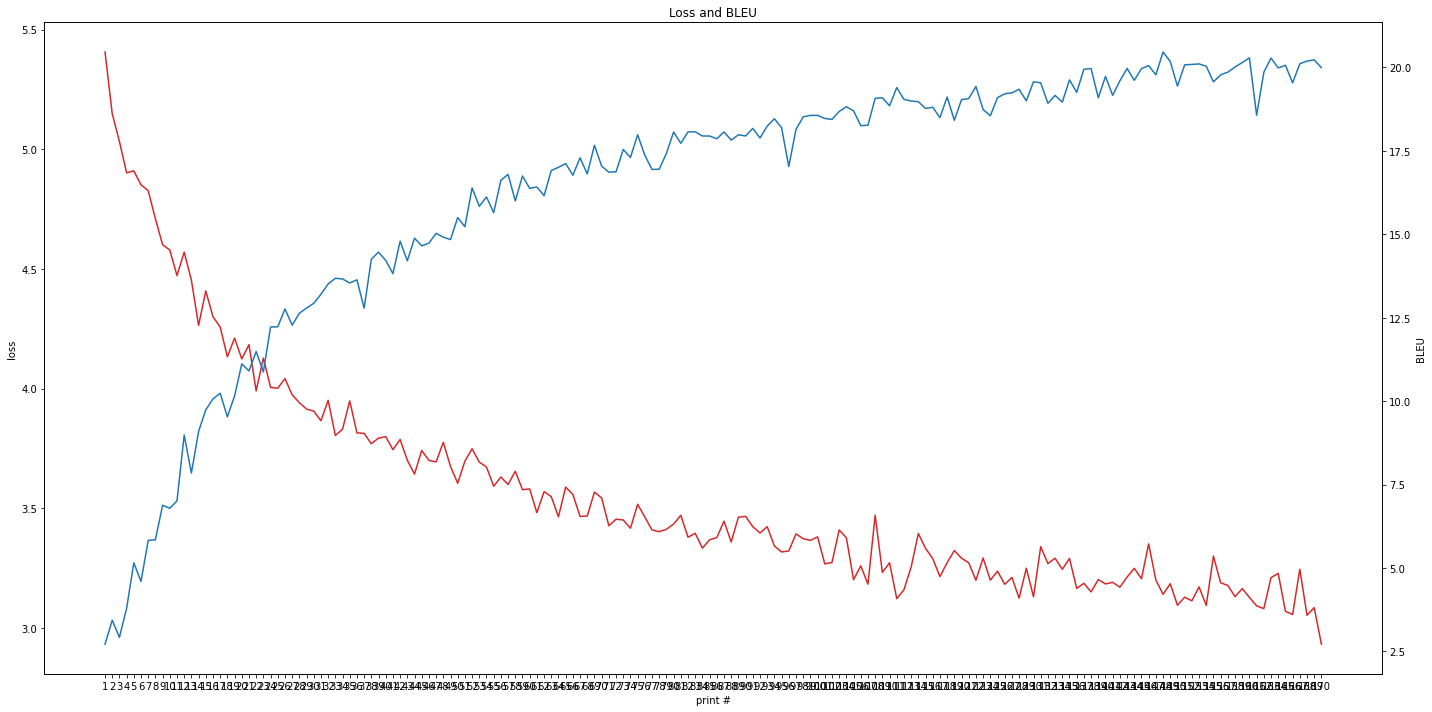

Streaming output truncated to the last 5000 lines.
Input      : le parlement marque son accord
Target     : parliament gave its assent
Translate  : parliament agreed its assent

18137 / 19135
Input      : qui souhaite intervenir pour defendre cette proposition
Target     : who wishes to speak in favour of this proposal
Translate  : who is for this for this this this

18138 / 19135
Input      : le parlement approuve la demande
Target     : parliament approved the request
Translate  : parliament approved the request

18139 / 19135
Input      : il s agit des demandes suivantes
Target     : these requests are as follows
Translate  : it is to to to

18140 / 19135
Input      : il est age
Target     : he is an old man
Translate  : it is a

18141 / 19135
Input      : pourquoi estce urgent
Target     : why is this urgent
Translate  : why is this this

18142 / 19135
Input      : cest tout ce que je tiens a dire
Target     : my case rests there
Translate  : that is all i i say

18143 / 19135
Inpu

In [ ]:
import os
import time
import math
import random
import numpy as np

import torch
import torch.nn as nn
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# reload sentences
input_sen, target_sen = load_sentence()

# build dictionaries
input_w2i, input_i2w = build_dictionary(input_sen)
target_w2i, target_i2w = build_dictionary(target_sen)

# parameters
ratio_train_test_split = 0.9
teacher_forcing_ratio = 0.5
input_size = len(input_w2i)
output_size = len(target_w2i)
embedding_size = 300
hidden_size = 300
num_epoch = 1
max_length = 10
ratio_train_validation_split = 0.99

# split the train and test sets
input_sen_tr, input_sen_te, target_sen_tr, target_sen_te = train_test_split(input_sen,target_sen,train_ratio=ratio_train_test_split,shuffle_sen=False,test_type="test")

# instantiate models
model_encoder = GRUEncoder(input_size = input_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = None).to(device)
model_decoder= GRUAttnDecoder(output_size = output_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = None).to(device)

# training
loss, bleu = train(input_w2i, input_sen_tr, target_w2i, target_sen_tr, model_encoder, model_decoder, model_save_at="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/", \
             model_type="gru_attention_without_pretrained_weights", num_epoch=num_epoch, print_interval=1000, learning_rate=1e-2, \
             train_ratio=ratio_train_validation_split, max_length=max_length, continue_training=False, shuffle_sen=True)

# plot the loss and BLEU
plot_loss_bleu(loss, bleu, 20, 10)

# test after training
evaluate(input_w2i, input_i2w, input_sen_te, target_w2i, target_i2w, target_sen_te, model_encoder, model_decoder, max_length=10, model_type="gru_attention_without_pretrained_weights", verbose=True)

###4.9.2 2nd run - 1 epoch - learning rate = 1e-3

In [ ]:
import os
import time
import math
import random
import numpy as np

import torch
import torch.nn as nn
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# reload sentences
input_sen, target_sen = load_sentence()

# build dictionaries
input_w2i, input_i2w = build_dictionary(input_sen)
target_w2i, target_i2w = build_dictionary(target_sen)

# parameters
ratio_train_test_split = 0.9
teacher_forcing_ratio = 0.5
input_size = len(input_w2i)
output_size = len(target_w2i)
embedding_size = 300
hidden_size = 300
num_epoch = 1
max_length = 10
ratio_train_validation_split = 0.99

# split the train and test sets
input_sen_tr, input_sen_te, target_sen_tr, target_sen_te = train_test_split(input_sen,target_sen,train_ratio=ratio_train_test_split,shuffle_sen=False,test_type="test")

# instantiate models
model_encoder = GRUEncoder(input_size = input_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = None).to(device)
model_decoder= GRUAttnDecoder(output_size = output_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = None).to(device)

# training
loss, bleu = train(input_w2i, input_sen_tr, target_w2i, target_sen_tr, model_encoder, model_decoder, model_save_at="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/", \
             model_type="gru_attention_without_pretrained_weights", num_epoch=num_epoch, print_interval=1000, learning_rate=1e-3, \
             train_ratio=ratio_train_validation_split, max_length=max_length, continue_training=True, shuffle_sen=True)

# plot the loss and BLEU
plot_loss_bleu(loss, bleu, 20, 10)

# test after training
evaluate(input_w2i, input_i2w, input_sen_te, target_w2i, target_i2w, target_sen_te, model_encoder, model_decoder, max_length=10, model_type="gru_attention_without_pretrained_weights", verbose=True)

### 4.9.3 3rd run - 1 epoch - learning rate = 1e-4

In [ ]:
import os
import time
import math
import random
import numpy as np

import torch
import torch.nn as nn
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# reload sentences
input_sen, target_sen = load_sentence()

# build dictionaries
input_w2i, input_i2w = build_dictionary(input_sen)
target_w2i, target_i2w = build_dictionary(target_sen)

# parameters
ratio_train_test_split = 0.9
teacher_forcing_ratio = 0.5
input_size = len(input_w2i)
output_size = len(target_w2i)
embedding_size = 300
hidden_size = 300
num_epoch = 1
max_length = 10
ratio_train_validation_split = 0.99

# split the train and test sets
input_sen_tr, input_sen_te, target_sen_tr, target_sen_te = train_test_split(input_sen,target_sen,train_ratio=ratio_train_test_split,shuffle_sen=False,test_type="test")

# instantiate models
model_encoder = GRUEncoder(input_size = input_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = None).to(device)
model_decoder= GRUAttnDecoder(output_size = output_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = None).to(device)

# training
loss, bleu = train(input_w2i, input_sen_tr, target_w2i, target_sen_tr, model_encoder, model_decoder, model_save_at="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/", \
             model_type="gru_attention_without_pretrained_weights", num_epoch=num_epoch, print_interval=1000, learning_rate=1e-4, \
             train_ratio=ratio_train_validation_split, max_length=max_length, continue_training=True, shuffle_sen=True)

# plot the loss and BLEU
plot_loss_bleu(loss, bleu, 20, 10)

# test after training
evaluate(input_w2i, input_i2w, input_sen_te, target_w2i, target_i2w, target_sen_te, model_encoder, model_decoder, max_length=10, model_type="gru_attention_without_pretrained_weights", verbose=True)

##4.10 Evaluate Only - GRU Encoder/Attention-Decoder without FastText weights loaded at the embedding layer

In [ ]:
import numpy as np

import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# reload sentences
input_sen, target_sen = load_sentence()

# build dictionaries
input_w2i, input_i2w = build_dictionary(input_sen)
target_w2i, target_i2w = build_dictionary(target_sen)

# parameters
ratio_train_test_split = 0.9
input_size = len(input_w2i)
output_size = len(target_w2i)
embedding_size = 300
hidden_size = 300
max_length = 10

# split the train and test sets
_, input_sen_te, _, target_sen_te = train_test_split(input_sen,target_sen,train_ratio=ratio_train_test_split,shuffle_sen=False,test_type="test")

# instantiate models
model_encoder = GRUEncoder(input_size = input_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = None).to(device)
model_decoder= GRUAttnDecoder(output_size = output_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = None).to(device)

# load saved models
model_encoder.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/model_encoder_gru_attention_without_pretrained_weights.pth"))
model_encoder.eval()
model_decoder.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/model_decoder_gru_attention_without_pretrained_weights.pth"))
model_decoder.eval()

# evaluate
evaluate(input_w2i, input_i2w, input_sen_te, target_w2i, target_i2w, target_sen_te, model_encoder, model_decoder, max_length=10, model_type="gru_attention_without_pretrained_weights", verbose=True)

##4.11 Train - GRU Encoder/Attention-Decoder with embedding layer being freezed

###4.11.1 1st run - 1 epoch - learning rate = 1e-2

/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/input_sen.pkl loaded
/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/target_sen.pkl loaded
172211 sentences in the train set. 19135 sentences in the test set. The test set will be reserved for evaluation.
Pretrained weights at /content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/cc.fr.300.vec.pkl loaded
Pretrained weights at /content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/cc.en.300.vec.pkl loaded
Pretrained weights for embedding layer obtained!
GRU Encoder embedding layer initialized with the FastText weights:
 tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0425, -0.0035,  0.0066,  ...,  0.0714, -0.0167,  0.0370],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0186, -0.0930,  0.0828,  ..., -0.0615,  0.0133,  0.0909],
        [-0.0340, -0.0118,  0.017

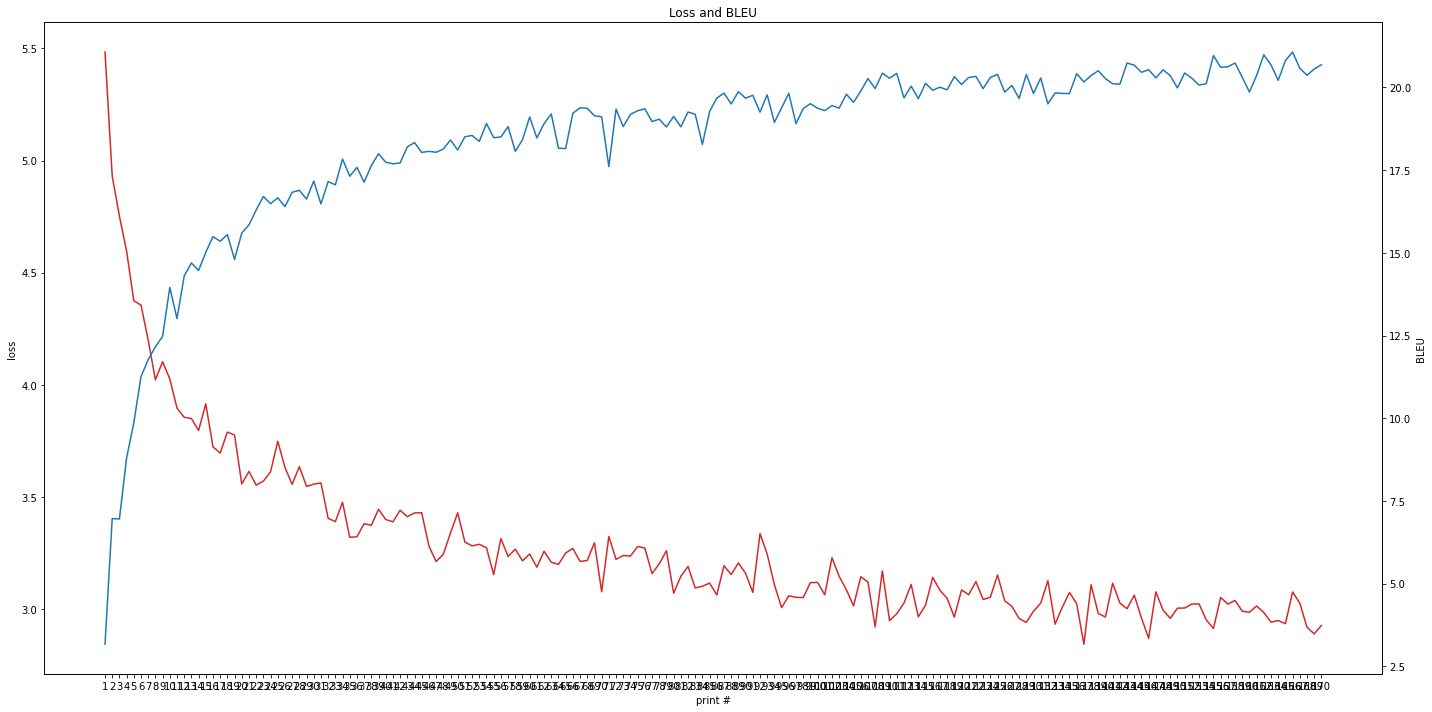

Streaming output truncated to the last 5000 lines.
Input      : le parlement marque son accord
Target     : parliament gave its assent
Translate  : parliament gave its assent

18137 / 19135
Input      : qui souhaite intervenir pour defendre cette proposition
Target     : who wishes to speak in favour of this proposal
Translate  : who wish to speak the proposal

18138 / 19135
Input      : le parlement approuve la demande
Target     : parliament approved the request
Translate  : parliament agreed the request

18139 / 19135
Input      : il s agit des demandes suivantes
Target     : these requests are as follows
Translate  : it is about the

18140 / 19135
Input      : il est age
Target     : he is an old man
Translate  : it is a

18141 / 19135
Input      : pourquoi estce urgent
Target     : why is this urgent
Translate  : why

18142 / 19135
Input      : cest tout ce que je tiens a dire
Target     : my case rests there
Translate  : that is quite i say

18143 / 19135
Input      : cest une qu

In [ ]:
import os
import time
import math
import random
import numpy as np

import torch
import torch.nn as nn
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# reload sentences
input_sen, target_sen = load_sentence()

# build dictionaries
input_w2i, input_i2w = build_dictionary(input_sen)
target_w2i, target_i2w = build_dictionary(target_sen)

# parameters
ratio_train_test_split = 0.9
teacher_forcing_ratio = 0.5
input_size = len(input_w2i)
output_size = len(target_w2i)
embedding_size = 300
hidden_size = 300
num_epoch = 1
max_length = 10
ratio_train_validation_split = 0.99

# split the train and test sets
input_sen_tr, input_sen_te, target_sen_tr, target_sen_te = train_test_split(input_sen,target_sen,train_ratio=ratio_train_test_split,shuffle_sen=False,test_type="test")


# obtain the FastText embedding weights
prepare_encoder_weights = PreparePretrainedWeight(input_w2i,input_i2w,embedding_size,fasttext_directory_path="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/",lang_type="fr", rebuild_wordvector=False)
emb_weights_encoder = prepare_encoder_weights.generate_emb_weights()
prepare_decoder_weights = PreparePretrainedWeight(target_w2i,target_i2w,embedding_size,fasttext_directory_path="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/",lang_type="en", rebuild_wordvector=False)
emb_weights_decoder = prepare_decoder_weights.generate_emb_weights()
print("Pretrained weights for embedding layer obtained!")

# instantiate models
model_encoder = GRUEncoder(input_size = input_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = emb_weights_encoder, freeze_emb=True).to(device)
model_decoder= GRUAttnDecoder(output_size = output_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = emb_weights_decoder, freeze_emb=True).to(device)

# training
loss, bleu = train(input_w2i, input_sen_tr, target_w2i, target_sen_tr, model_encoder, model_decoder, model_save_at="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/", \
             model_type="gru_attention_freeze_emb", num_epoch=num_epoch, print_interval=1000, learning_rate=1e-2, \
             train_ratio=ratio_train_validation_split, max_length=max_length, continue_training=False, shuffle_sen=True)

# plot the loss and BLEU
plot_loss_bleu(loss, bleu, 20, 10)

# test after training
evaluate(input_w2i, input_i2w, input_sen_te, target_w2i, target_i2w, target_sen_te, model_encoder, model_decoder, max_length=10, model_type="gru_attention_freeze_emb", verbose=True)

###4.11.2 2nd run - 1 epoch - learning rate = 1e-3

In [ ]:
import os
import time
import math
import random
import numpy as np

import torch
import torch.nn as nn
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# reload sentences
input_sen, target_sen = load_sentence()

# build dictionaries
input_w2i, input_i2w = build_dictionary(input_sen)
target_w2i, target_i2w = build_dictionary(target_sen)

# parameters
ratio_train_test_split = 0.9
teacher_forcing_ratio = 0.5
input_size = len(input_w2i)
output_size = len(target_w2i)
embedding_size = 300
hidden_size = 300
num_epoch = 1
max_length = 10
ratio_train_validation_split = 0.99

# split the train and test sets
input_sen_tr, input_sen_te, target_sen_tr, target_sen_te = train_test_split(input_sen,target_sen,train_ratio=ratio_train_test_split,shuffle_sen=False,test_type="test")


# obtain the FastText embedding weights
prepare_encoder_weights = PreparePretrainedWeight(input_w2i,input_i2w,embedding_size,fasttext_directory_path="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/",lang_type="fr", rebuild_wordvector=False)
emb_weights_encoder = prepare_encoder_weights.generate_emb_weights()
prepare_decoder_weights = PreparePretrainedWeight(target_w2i,target_i2w,embedding_size,fasttext_directory_path="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/",lang_type="en", rebuild_wordvector=False)
emb_weights_decoder = prepare_decoder_weights.generate_emb_weights()
print("Pretrained weights for embedding layer obtained!")

# instantiate models
model_encoder = GRUEncoder(input_size = input_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = emb_weights_encoder, freeze_emb=True).to(device)
model_decoder= GRUAttnDecoder(output_size = output_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = emb_weights_decoder, freeze_emb=True).to(device)

# training
loss, bleu = train(input_w2i, input_sen_tr, target_w2i, target_sen_tr, model_encoder, model_decoder, model_save_at="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/", \
             model_type="gru_attention_freeze_emb", num_epoch=num_epoch, print_interval=1000, learning_rate=1e-3, \
             train_ratio=ratio_train_validation_split, max_length=max_length, continue_training=True, shuffle_sen=True)

# plot the loss and BLEU
plot_loss_bleu(loss, bleu, 20, 10)

# test after training
evaluate(input_w2i, input_i2w, input_sen_te, target_w2i, target_i2w, target_sen_te, model_encoder, model_decoder, max_length=10, model_type="gru_attention_freeze_emb", verbose=True)

###4.11.3 3rd run- 1 epoch - learning rate = 1e-4

In [ ]:
import os
import time
import math
import random
import numpy as np

import torch
import torch.nn as nn
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# reload sentences
input_sen, target_sen = load_sentence()

# build dictionaries
input_w2i, input_i2w = build_dictionary(input_sen)
target_w2i, target_i2w = build_dictionary(target_sen)

# parameters
ratio_train_test_split = 0.9
teacher_forcing_ratio = 0.5
input_size = len(input_w2i)
output_size = len(target_w2i)
embedding_size = 300
hidden_size = 300
num_epoch = 1
max_length = 10
ratio_train_validation_split = 0.99

# split the train and test sets
input_sen_tr, input_sen_te, target_sen_tr, target_sen_te = train_test_split(input_sen,target_sen,train_ratio=ratio_train_test_split,shuffle_sen=False,test_type="test")


# obtain the FastText embedding weights
prepare_encoder_weights = PreparePretrainedWeight(input_w2i,input_i2w,embedding_size,fasttext_directory_path="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/",lang_type="fr", rebuild_wordvector=False)
emb_weights_encoder = prepare_encoder_weights.generate_emb_weights()
prepare_decoder_weights = PreparePretrainedWeight(target_w2i,target_i2w,embedding_size,fasttext_directory_path="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/",lang_type="en", rebuild_wordvector=False)
emb_weights_decoder = prepare_decoder_weights.generate_emb_weights()
print("Pretrained weights for embedding layer obtained!")

# instantiate models
model_encoder = GRUEncoder(input_size = input_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = emb_weights_encoder, freeze_emb=True).to(device)
model_decoder= GRUAttnDecoder(output_size = output_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = emb_weights_decoder, freeze_emb=True).to(device)

# training
loss, bleu = train(input_w2i, input_sen_tr, target_w2i, target_sen_tr, model_encoder, model_decoder, model_save_at="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/", \
             model_type="gru_attention_freeze_emb", num_epoch=num_epoch, print_interval=1000, learning_rate=1e-4, \
             train_ratio=ratio_train_validation_split, max_length=max_length, continue_training=True, shuffle_sen=True)

# plot the loss and BLEU
plot_loss_bleu(loss, bleu, 20, 10)

# test after training
evaluate(input_w2i, input_i2w, input_sen_te, target_w2i, target_i2w, target_sen_te, model_encoder, model_decoder, max_length=10, model_type="gru_attention_freeze_emb", verbose=True)

##4.12 Evaluate Only - GRU Encoder/Attention-Decoder with embedding layer being freezed

In [ ]:
import numpy as np

import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# reload sentences
input_sen, target_sen = load_sentence()

# build dictionaries
input_w2i, input_i2w = build_dictionary(input_sen)
target_w2i, target_i2w = build_dictionary(target_sen)

# parameters
ratio_train_test_split = 0.9
input_size = len(input_w2i)
output_size = len(target_w2i)
embedding_size = 300
hidden_size = 300
max_length = 10

# split the train and test sets
_, input_sen_te, _, target_sen_te = train_test_split(input_sen,target_sen,train_ratio=ratio_train_test_split,shuffle_sen=False,test_type="test")

# obtain the FastText embedding weights
prepare_encoder_weights = PreparePretrainedWeight(input_w2i,input_i2w,embedding_size,fasttext_directory_path="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/",lang_type="fr", rebuild_wordvector=False)
emb_weights_encoder = prepare_encoder_weights.generate_emb_weights()
prepare_decoder_weights = PreparePretrainedWeight(target_w2i,target_i2w,embedding_size,fasttext_directory_path="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/",lang_type="en", rebuild_wordvector=False)
emb_weights_decoder = prepare_decoder_weights.generate_emb_weights()
print("Pretrained weights for embedding layer obtained!")

# instantiate models
model_encoder = GRUEncoder(input_size = input_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = emb_weights_encoder, freeze_emb=True).to(device)
model_decoder= GRUAttnDecoder(output_size = output_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = emb_weights_decoder, freeze_emb=True).to(device)

# load saved models
model_encoder.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/model_encoder_gru_attention_freeze_emb.pth"))
model_encoder.eval()
model_decoder.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/model_decoder_gru_attention_freeze_emb.pth"))
model_decoder.eval()

# evaluate
evaluate(input_w2i, input_i2w, input_sen_te, target_w2i, target_i2w, target_sen_te, model_encoder, model_decoder, max_length=10, model_type="gru_attention_freeze_emb", verbose=True)


Streaming output truncated to the last 5000 lines.
Input      : le parlement marque son accord
Target     : parliament gave its assent
Translate  : parliament gave its assent

18137 / 19135
Input      : qui souhaite intervenir pour defendre cette proposition
Target     : who wishes to speak in favour of this proposal
Translate  : who wish to speak for this proposal

18138 / 19135
Input      : le parlement approuve la demande
Target     : parliament approved the request
Translate  : parliament approved the request

18139 / 19135
Input      : il s agit des demandes suivantes
Target     : these requests are as follows
Translate  : it is a first of the

18140 / 19135
Input      : il est age
Target     : he is an old man
Translate  : it is is

18141 / 19135
Input      : pourquoi estce urgent
Target     : why is this urgent
Translate  : why is this is

18142 / 19135
Input      : cest tout ce que je tiens a dire
Target     : my case rests there
Translate  : that is all i i say

18143 / 19135


# 5.Final Evaluation - different model on the same testing set

In [6]:
import numpy as np

import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# reload sentences
input_sen, target_sen = load_sentence()

# build dictionaries
input_w2i, input_i2w = build_dictionary(input_sen)
target_w2i, target_i2w = build_dictionary(target_sen)

# parameters
ratio_train_test_split = 0.9
input_size = len(input_w2i)
output_size = len(target_w2i)
embedding_size = 300
max_length = 10

# split the train and test sets
_, input_sen_te, _, target_sen_te = train_test_split(input_sen,target_sen,train_ratio=ratio_train_test_split,shuffle_sen=False,test_type="test")

# obtain the FastText embedding weights
prepare_encoder_weights = PreparePretrainedWeight(input_w2i,input_i2w,embedding_size,fasttext_directory_path="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/",lang_type="fr", rebuild_wordvector=False)
emb_weights_encoder = prepare_encoder_weights.generate_emb_weights()
prepare_decoder_weights = PreparePretrainedWeight(target_w2i,target_i2w,embedding_size,fasttext_directory_path="/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/",lang_type="en", rebuild_wordvector=False)
emb_weights_decoder = prepare_decoder_weights.generate_emb_weights()
print("Pretrained weights for embedding layer obtained!")


models = ['rnn','lstm', 'gru', 'gru_attention', 'gru_attention_without_pretrained_weights', 'gru_attention_freeze_emb']
model_en_eva = []
model_de_eva = []
model_en_de_eva_path = []

for m in models:
  model_encoder = m.upper() + "Encoder" if "gru_attention" not in m else "GRUEncoder"
  emb_weights_encoder = emb_weights_encoder if "without" not in m else None
  freeze_emb = False if "freeze" not in m else True
  model_decoder = m.upper() + "Decoder" if "gru_attention" not in m else "GRUAttnDecoder"
  emb_weights_decoder = emb_weights_decoder if "without" not in m else None
  print(model_encoder, emb_weights_encoder, freeze_emb, model_decoder, emb_weights_decoder)

  hidden_size = 200 if "attention" not in m else 300
  # instantiate models and save it
  model_encoder = eval(model_encoder)(input_size = input_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = emb_weights_encoder, freeze_emb=freeze_emb).to(device)
  model_en_eva.append(model_encoder)
  model_decoder = eval(model_decoder)(output_size = output_size, embedding_size = embedding_size, hidden_size = hidden_size, emb_weights = emb_weights_decoder, freeze_emb=freeze_emb).to(device)
  model_de_eva.append(model_decoder)

  # save the path of models
  model_en_de_eva_path.append(m)

from IPython.display import clear_output
clear_output(wait=True)

# load saved models and evaluate
for idx in range(len(model_en_eva)):
  model_en_eva[idx].load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/model_encoder_"+model_en_de_eva_path[idx]+".pth", map_location=device))
  model_en_eva[idx].eval()
  model_de_eva[idx].load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/model_decoder_"+model_en_de_eva_path[idx]+".pth", map_location=device))
  model_de_eva[idx].eval()

  # evaluate
  print(model_en_de_eva_path[idx])
  evaluate(input_w2i, input_i2w, input_sen_te, target_w2i, target_i2w, target_sen_te, model_en_eva[idx], model_de_eva[idx], \
           max_length=10, model_type=model_en_de_eva_path[idx], verbose=True, carriage_return=True)


/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/input_sen.pkl loaded
/content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/target_sen.pkl loaded
172211 sentences in the train set. 19135 sentences in the test set. The test set will be reserved for evaluation.
Pretrained weights at /content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/cc.fr.300.vec.pkl loaded
Pretrained weights at /content/drive/MyDrive/Colab Notebooks/COMP5014/project/mt/cc.en.300.vec.pkl loaded
Pretrained weights for embedding layer obtained!
RNNEncoder 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



RNN Encoder embedding layer initialized with the FastText weights:
 tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0425, -0.0035,  0.0066,  ...,  0.0714, -0.0167,  0.0370],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0186, -0.0930,  0.0828,  ..., -0.0615,  0.0133,  0.0909],
        [-0.0340, -0.0118,  0.0172,  ..., -0.0180, -0.0333,  0.0610]])
RNN Decoder embedding layer initialized with the FastText weights:
 tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0971,  0.0305,  0.0208,  ...,  0.0154,  0.0099, -0.0300],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0300, -0.1416, -0.0157,  ...,  0.1411, -0.0833,  0.1233],
        [ 0.1075,  0.0724, -0.1023,  ...,  0.1857,  0.1905,  0.0073

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



LSTM Decoder embedding layer initialized with the FastText weights:
 tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0971,  0.0305,  0.0208,  ...,  0.0154,  0.0099, -0.0300],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0300, -0.1416, -0.0157,  ...,  0.1411, -0.0833,  0.1233],
        [ 0.1075,  0.0724, -0.1023,  ...,  0.1857,  0.1905,  0.0073]])
GRUEncoder 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



GRU Encoder embedding layer initialized with the FastText weights:
 tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0425, -0.0035,  0.0066,  ...,  0.0714, -0.0167,  0.0370],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0186, -0.0930,  0.0828,  ..., -0.0615,  0.0133,  0.0909],
        [-0.0340, -0.0118,  0.0172,  ..., -0.0180, -0.0333,  0.0610]])
GRU Decoder embedding layer initialized with the FastText weights:
 tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0971,  0.0305,  0.0208,  ...,  0.0154,  0.0099, -0.0300],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0300, -0.1416, -0.0157,  ...,  0.1411, -0.0833,  0.1233],
        [ 0.1075,  0.0724, -0.1023,  ...,  0.1857,  0.1905,  0.0073

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



GRU Decoder with attention embedding layer initialized with the FastText weights:
 tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0971,  0.0305,  0.0208,  ...,  0.0154,  0.0099, -0.0300],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0300, -0.1416, -0.0157,  ...,  0.1411, -0.0833,  0.1233],
        [ 0.1075,  0.0724, -0.1023,  ...,  0.1857,  0.1905,  0.0073]])
GRUEncoder None False GRUAttnDecoder None
GRU Encoder embedding layer randomly initialized.
GRU Decoder with attention embedding layer randomly initialized.
GRUEncoder None True GRUAttnDecoder None
GRU Encoder embedding layer randomly initialized.
GRU Encoder embedding layer is freezed.
GRU Decoder with attention embedding layer randomly initialized.
GRU Decoder with attention embedding layer is freezed.
rnn
Evaluating 19135 / 19135 BLEU: 14.55
lstm
Evaluating 19135 / 19135 BLEU